In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import scirpy as ir
import decoupler as dc
# import scrublet as scr
import muon as mu
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi
from adjustText import adjust_text
import re

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

2025-01-06 14:10:52.559121: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 14:10:53.354155: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 14:10:53.732589: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 14:10:53.843907: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 14:10:54.530106: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '241212_CSF_VDJ'
# input_table = '../data/231009_PBMC_HH514.csv'

results_file = '../scanpy/{}/{}.h5ad'.format(version, version)
results_file_mu = '../scanpy/{}/{}.h5mu'.format(version, version)
results_file_cellxgene = '../scanpy/{}/{}.cxg.h5ad'.format(version, version)

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.11.4 pandas==2.0.3 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
adata = sc.read('/home/yy693/pi_hafler/ASAP/scanpy/241028_CSF_downstream/res.h5ad')
# adata.obs['Hyposmia'] = adata.obs['UPSITPercentile'] <= 15
# adata.obs['Diagnosis_RBDstrat'] = adata.obs['EnrollmentCategory'].astype(str)
# # adata.obs['Diagnosis_RBDstrat'] + '_' + adata.obs['Hyposmia'].astype(str)
# adata.obs.loc[(adata.obs['EnrollmentCategory'] == 'RBD') & (adata.obs['Hyposmia']), 'Diagnosis_RBDstrat'] = 'RBD_Hyposmia_pos'
# adata.obs.loc[(adata.obs['EnrollmentCategory'] == 'RBD') & (~ adata.obs['Hyposmia']), 'Diagnosis_RBDstrat'] = 'RBD_Hyposmia_neg'

In [4]:
adata

AnnData object with n_obs × n_vars = 259560 × 24155
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLB

In [5]:
f_file_list = '/home/yy693/pi_hafler/ASAP/data/250106_cellranger_files_VDJ.csv'


df_file = pd.read_csv(f_file_list)
df_file = df_file[df_file['SampleType'] == 'CSF']

In [6]:
df_file

path  \
2    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
3    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
6    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
7    /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
10   /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
..                                                 ...   
292  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
295  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
296  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
299  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   
300  /home/yy693/pi_hafler/ASAP/output/cellranger/2...   

                                directory   cellranger_sample_id   SampleID  \
2                      20220523_lz438_vdj  YPD001CSF_BCR_VHT_VDJ  YPD001CSF   
3                      20220523_lz438_vdj  YPD001CSF_TCR_VHT_VDJ  YPD001CSF   
6                      20220523_lz438_vdj  YPD002CSF_BCR_VHT_VDJ  YPD002CSF   
7                      20220523_lz438_vdj  YPD002CSF_TCR_VHT_VDJ  YPD002CSF   
10                     20220523_lz438_vdj  YPD003CSF_BCR_VHT_VDJ  YPD003CSF   
..                                    ...                    ...        ...   
292  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD093CSF_TCR_VHT_VDJ  YPD093CSF   
295  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD096CSF_BCR_VHT_VDJ  YPD096CSF   
296  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD096CSF_TCR_VHT_VDJ  YPD096CSF   
299  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD097CSF_BCR_VHT_VDJ  YPD097CSF   
300  20250102_lz438_22G52FLT4_RQ32646_vdj  YPD097CSF_TCR_VHT_VDJ  YPD097CSF   

    experiment SampleType DonorID vdj_type Estimated Number of Cells  \
2          VDJ        CSF  YPD001      BCR                        14   
3          VDJ        CSF  YPD001      TCR                       890   
6          VDJ        CSF  YPD002      BCR                        39   
7          VDJ        CSF  YPD002      TCR                     2,281   
10         VDJ        CSF  YPD003      BCR                       170   
..         ...        ...     ...      ...                       ...   
292        VDJ        CSF  YPD093      TCR                     2,365   
295        VDJ        CSF  YPD096      BCR                        59   
296        VDJ        CSF  YPD096      TCR                     1,391   
299        VDJ        CSF  YPD097      BCR                        10   
300        VDJ        CSF  YPD097      TCR                     2,220   

    Mean Read Pairs per Cell  ...  \
2                  5,188,061  ...   
3                     70,120  ...   
6                  1,755,525  ...   
7                     36,349  ...   
10                   453,685  ...   
..                       ...  ...   
292                   41,347  ...   
295                1,841,055  ...   
296                   80,210  ...   
299               11,686,794  ...   
300                   35,936  ...   

    Cells With Productive V-J Spanning (TRA, TRB) Pair Cells With TRA Contig  \
2                                                  NaN                   NaN   
3                                                89.8%                 95.6%   
6                                                  NaN                   NaN   
7                                                81.5%                 91.1%   
10                                                 NaN                   NaN   
..                                                 ...                   ...   
292                                              79.6%                 87.4%   
295                                                NaN                   NaN   
296                                              80.5%                 87.9%   
299                                                NaN                   NaN   
300                                              83.4%                 90.7%   

    Cells With TRB Contig Cells With CDR3-annotated TRA Contig  \
2                     NaN                                  NaN   
3

In [7]:
df_file.iloc[0].path

'/home/yy693/pi_hafler/ASAP/output/cellranger/20220523_lz438_vdj/YPD001CSF_BCR_VHT_VDJ/outs'

In [8]:
list_cols = ['cellranger_sample_id', 'SampleID', 
       'SampleType', 'DonorID']
       
dict_adata_tcr = {}
for pos,row in df_file[df_file['vdj_type']=='TCR'].iterrows():
    a = ir.io.read_airr(f"{row['path']}/airr_rearrangement.tsv")
    a.var_names_make_unique()
    for col in list_cols:
        a.obs[col] = row[col]

    # sc.pp.scrublet(a, expected_doublet_rate=doublet_rate(a.shape[0], row['chemistry']))

    dict_adata_tcr[row['SampleID']] = a

adata_tcr = sc.concat(dict_adata_tcr, join='outer', index_unique='-')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/utils.py:346: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/utils.py:346: ExperimentalFeatureWarning: Outer joins on awkward.Arrays will have different return values in the future. For details, and to offer input, please see:

	https://github.com/scverse/anndata/issues/898
  warnings.warn(msg, category, stacklevel=stacklevel)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [9]:
adata_tcr.obs

cellranger_sample_id   SampleID SampleType  \
cell_id                                                                     
AAACCTGAGACTTGAA-1-YPD001CSF  YPD001CSF_TCR_VHT_VDJ  YPD001CSF        CSF   
AAACCTGGTATGAAAC-1-YPD001CSF  YPD001CSF_TCR_VHT_VDJ  YPD001CSF        CSF   
AAACGGGCACGCTTTC-1-YPD001CSF  YPD001CSF_TCR_VHT_VDJ  YPD001CSF        CSF   
AAAGATGCATGCAATC-1-YPD001CSF  YPD001CSF_TCR_VHT_VDJ  YPD001CSF        CSF   
AAAGATGGTTGTGGAG-1-YPD001CSF  YPD001CSF_TCR_VHT_VDJ  YPD001CSF        CSF   
...                                             ...        ...        ...   
TTTGTCAAGTGGTAAT-1-YPD097CSF  YPD097CSF_TCR_VHT_VDJ  YPD097CSF        CSF   
TTTGTCACATGCAATC-1-YPD097CSF  YPD097CSF_TCR_VHT_VDJ  YPD097CSF        CSF   
TTTGTCAGTACCATCA-1-YPD097CSF  YPD097CSF_TCR_VHT_VDJ  YPD097CSF        CSF   
TTTGTCAGTTTCGCTC-1-YPD097CSF  YPD097CSF_TCR_VHT_VDJ  YPD097CSF        CSF   
TTTGTCATCCCACTTG-1-YPD097CSF  YPD097CSF_TCR_VHT_VDJ  YPD097CSF        CSF   

                             DonorID  
cell_id                               
AAACCTGAGACTTGAA-1-YPD001CSF  YPD001  
AAACCTGGTATGAAAC-1-YPD001CSF  YPD001  
AAACGGGCACGCTTTC-1-YPD001CSF  YPD001  
AAAGATGCATGCAATC-1-YPD001CSF  YPD001  
AAAGATGGTTGTGGAG-1-YPD001CSF  YPD001  
...                              ...  
TTTGTCAAGTGGTAAT-1-YPD097CSF  YPD097  
TTTGTCACATGCAATC-1-YPD097CSF  YPD097  
TTTGTCAGTACCATCA-1-YPD097CSF  YPD097  
TTTGTCAGTTTCGCTC-1-YPD097CSF  YPD097  
TTTGTCATCCCACTTG-1-YPD097CSF  YPD097  

[231722 rows x 4 columns]

In [10]:
dict_adata_bcr = {}
for pos,row in df_file[df_file['vdj_type']=='BCR'].iterrows():
    if int(row['Estimated Number of Cells'].replace(',','')) > 0:
        a = ir.io.read_airr(f"{row['path']}/airr_rearrangement.tsv")
        a.var_names_make_unique()
        for col in list_cols:
            a.obs[col] = row[col]

        # sc.pp.scrublet(a, expected_doublet_rate=doublet_rate(a.shape[0], row['chemistry']))

        dict_adata_bcr[row['SampleID']] = a

adata_bcr = sc.concat(dict_adata_bcr, join='outer', index_unique='-')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [11]:
adata_bcr

AnnData object with n_obs × n_vars = 9869 × 0
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID'
    obsm: 'airr'

In [12]:
ir.pp.index_chains(adata_tcr)
ir.tl.chain_qc(adata_tcr)
adata_tcr = adata_tcr[adata_tcr.obs['receptor_type'] == 'TCR']

ir.pp.index_chains(adata_bcr)
ir.tl.chain_qc(adata_bcr)
adata_bcr = adata_bcr[adata_bcr.obs['receptor_type'] == 'BCR']

Filtering chains...


Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.
Filtering chains...
Indexing VJ chains...
Indexing VDJ chains...
build result array
Stored result in `adata.obs["receptor_type"]`.
Stored result in `adata.obs["receptor_subtype"]`.
Stored result in `adata.obs["chain_pairing"]`.


In [13]:
mdata = mu.MuData({"gex": adata, "tcr": adata_tcr, "bcr": adata_bcr})

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [14]:
mdata

MuData object with n_obs × n_vars = 331058 × 24155
  3 modalities
    gex:	259560 x 24155
      obs:	'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLBAAO', 'AgeDLBDx', 'DLBDxtoConsent', 'PSGinEpic?', 'BirthYear', 'MeetsMDSPDCriteria?', 'PSGDate', 'Ethnicity', 'Race', 'RaceOther', 'PDFamilyHx', 'PDFHMother', 'PDFHFather', 'PDFHFullSibs', 'PDFHHalfSibs', 'PDFHMaternalGPs', 'PDFHPaternalGPs', 'PDFHMaternalAuntsorUncles', 'PDFHChildren', 'PDFHOther', 'DLBFamilyHx', 'DLBFHMother', 'DLBFHFather', 'DLBFHFullSibs', 'DLBFHHalfSibs', 'DLBFHMaternalGPs', 'DLBFHPaternalGPs', 'DLBFHMaternalAuntsorUncles', 'DLBFHChildren', 'DLBFHOther', 'MSAFamilyHx', 'MSAFHMother', 'MSAFHFather', 'MSAFHFullSibs', 'MSAFHHalfSibs', 'MSAFHMaternalGPs', 'MSAFHPaternalGPs', 'MSAFHMaternalAuntsorUncles', 'MSAFHChildren', 'MSAFHOther', 'PDRiskPesticideExposure', 'PDRiskOccupationalsolventExposure', 'PDRiskDrinksCaffeinatedBeverages', 'PDRiskSmokerorFormerSmoker', 'PDRiskPhysicallyActive', 'MeanStriatumSBR', 'MeanStriatumSBR%ile', 'Caudate/PutamenRatio', 'AssymetryIndex', 'OrthostaticHypotension?', 'BloodyTap?', 'ClinicalCSFDataObtained?', 'CSFProtein', 'CSFGlucose', 'ClinicalCSFRBC', 'ClinicalCSFTotalNucleatedCells', 'ClinicalCSFGranulocytes', 'ClinicalCSFLymphocytes', 'CSFClinicalMonocytes', 'CSFVolume', 'CSFTotalCells', 'CSFCells/uL', 'CSFNotes', 'CSFSAA', 'UPSITRawScore', 'UPSITPercentile', 'MOCAVisuospatial', 'MOCA2Naming', 'MOCAMemoryTrial1', 'MOCAMemoryTrial2', 'MOCAAttention', 'MOCALanguage', 'MOCAAbstraction', 'MOCADelayedRecall', 'MOCAMemoryIndexScore', 'MOCAOrientation', 'MOCATotal', 'ParisArousalTotal', 'ConstipationCriteriaScore', 'BMSQ1RisingfromChair', 'BMSQ2Handwriting', 'BMSQ3VoiceSofter', 'BMSQ4PoorBalance', 'BMSQ5FeetGettingStuck', 'BMSQ6FaceLessExpressive', 'BMSQ7ArmsorLegsShaking', 'BMSQ8Buttons', 'BMSQ9Shuffling', 'BMSQ10MoveMoreSlowlythanOthersofAge', 'BMSQTotal', 'LRScore', 'ProbableProdromalPD?', 'SCOPATotal', 'SCPOPAManualEntry', 'NMSSTotal', 'MDS-UPDRS1.1cognition', 'MDS-UPDRS1.2Hallucinations', 'MDS-UPDRS1.3Mood', 'MDS-UPDRS1.4Anxiety', 'MDS-UPDRS1.5Apathy', 'MDS-UPDRS1.6DOPADysregulation', 'MDS-UPDRS1.7Sleep', 'MDS-UPDRS1.8DaytimeSleepiness', 'MDS-UPDRS1.9Pain', 'UMD-UPDRS1.10Urological', 'MDS-UPDRS1.11Constipation', 'MDS-UPDRS1.12OrthostaticDizziness', 'MDS-UPDRS1.13Fatigue', 'MDS-UPDRS2.1Speech', 'MDS-UPDRS2.2Drooling', 'MDS-UPDRS2.3Swallowing', 'MDS-UPDRS2.4Eating', 'MDS-UPDRS2.5Dressing', 'MDS-UPDRS2.6Hygeine', 'MDS-UPDRS2.7Handwriting', 'MDS-UPDRS2.8Hobbies', 'MDS-UPDRS2.9TurninginBed', 'MDS-UPDRS2.10Tremor', 'MDS-UPDRS2.11RisingfromChair,Car,Bed', 'MDS-UPDRS2.12Walking', 'MDS-UPDRS2.13FreezingofGait', 'MDS-UPDRSTakingMeds', 'MDS-UPDRS3.1Speech', 'MDS-UPDRS3.2Facies', 'MDS-UPDRS3.3NeckRigidity', 'MDS-UPDRS3.3RUERigidity', 'MDS-UPDRS3.3LUERidigity', 'MDS-UPDRS3.3RLERidigity', 'MDS-UPDRS3.3LLERigidty', 'MDS-UPDRS3.4FingerTapsR', 'MDS-UPDRS3.4FingerTapsL', 'MDS-UPDRS3.5GraspR', 'MDS-UPDRS3.5GraspL', 'MDS-UPDRS3.6RSMR', 'MDS-UPDRS3.6RSML', 'MDS-UPDRS3.7ToeTapR', 'MDS-UPDRS3.7ToeTapL', 'MDS-UPDRS3.8LegAgilityR', 'MDS-UPDRS3.8LegAgilityL', 'MDS-UPDRS3.9RisingFromC

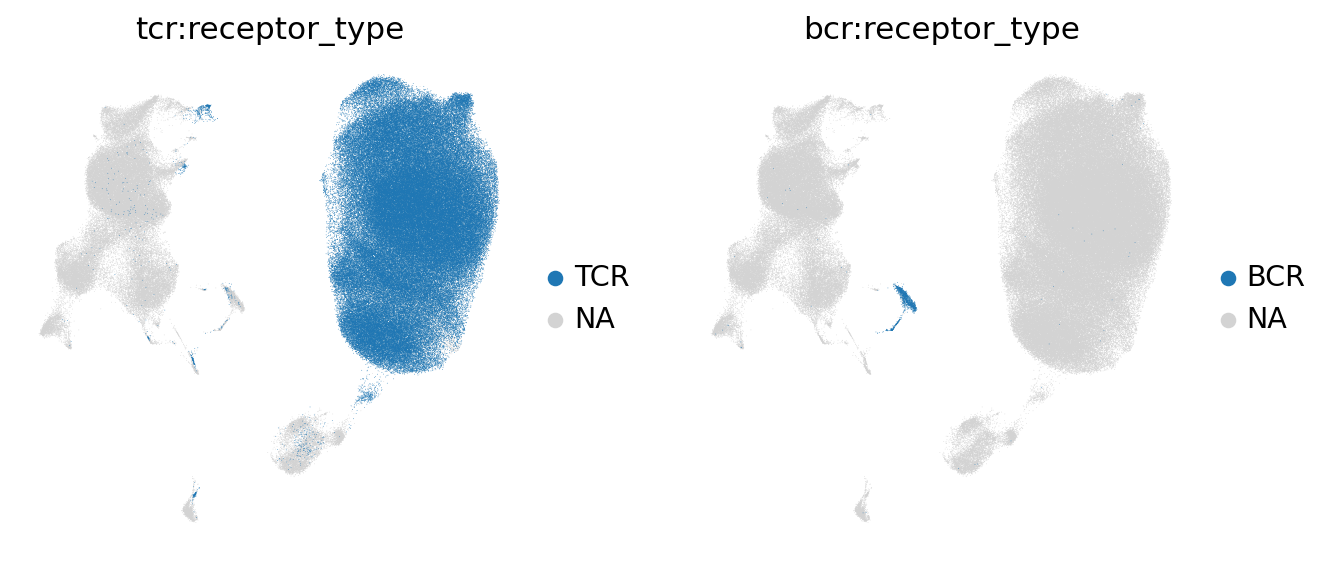

In [15]:
mu.pl.embedding(mdata, basis="gex:umap_filtered", color=["tcr:receptor_type", "bcr:receptor_type"])

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda

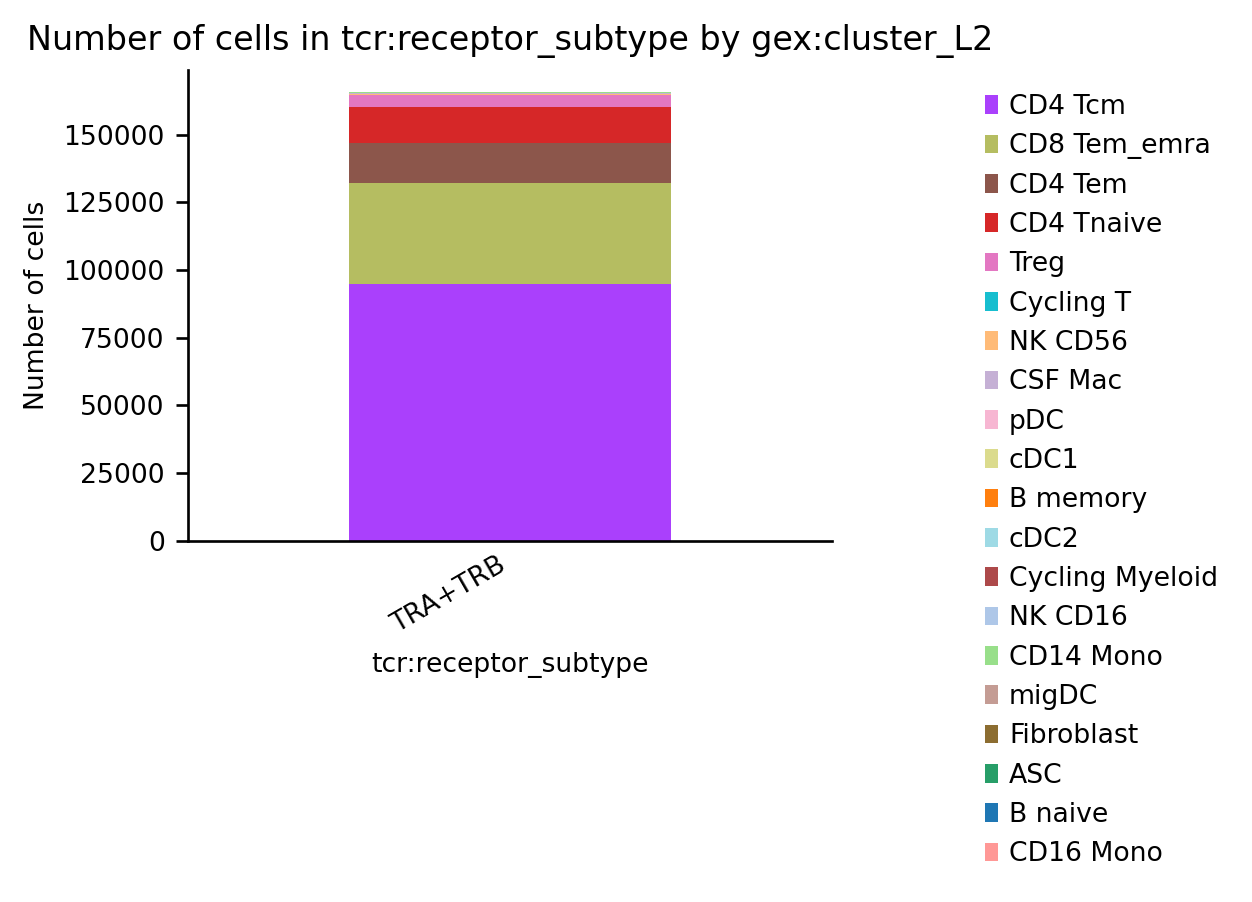

In [16]:
_ = ir.pl.group_abundance(mdata, groupby="tcr:receptor_subtype", target_col="gex:cluster_L2")

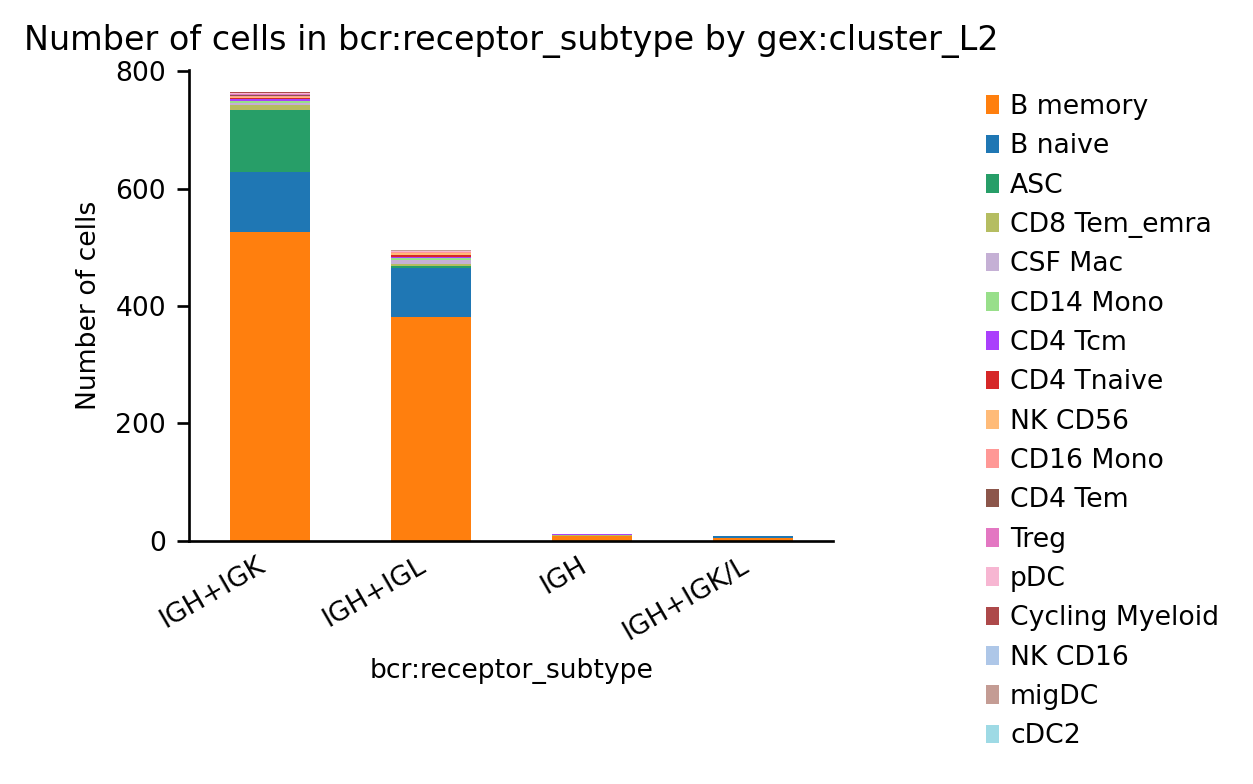

In [17]:
_ = ir.pl.group_abundance(mdata, groupby="bcr:receptor_subtype", target_col="gex:cluster_L2")

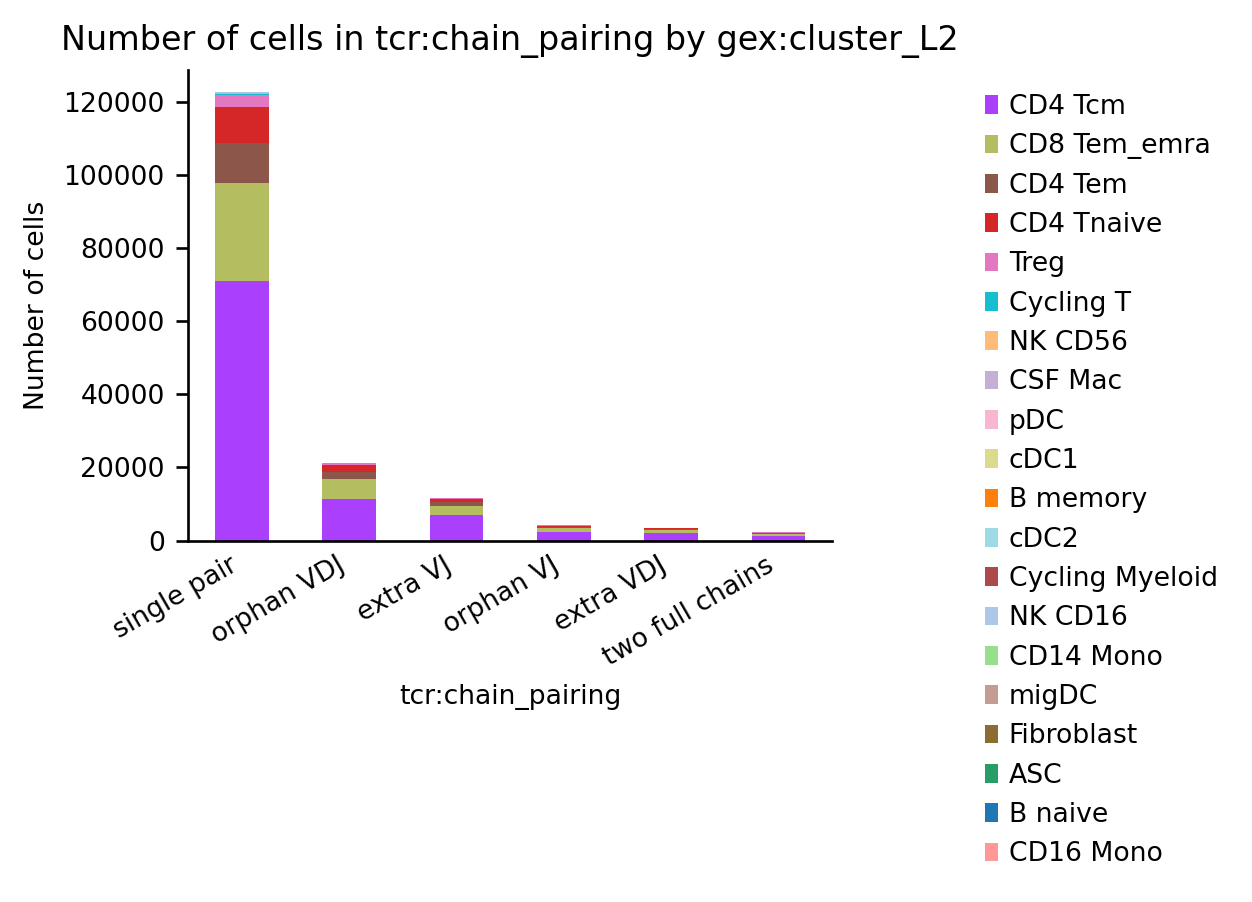

In [18]:
_ = ir.pl.group_abundance(mdata, groupby="tcr:chain_pairing", target_col="gex:cluster_L2")

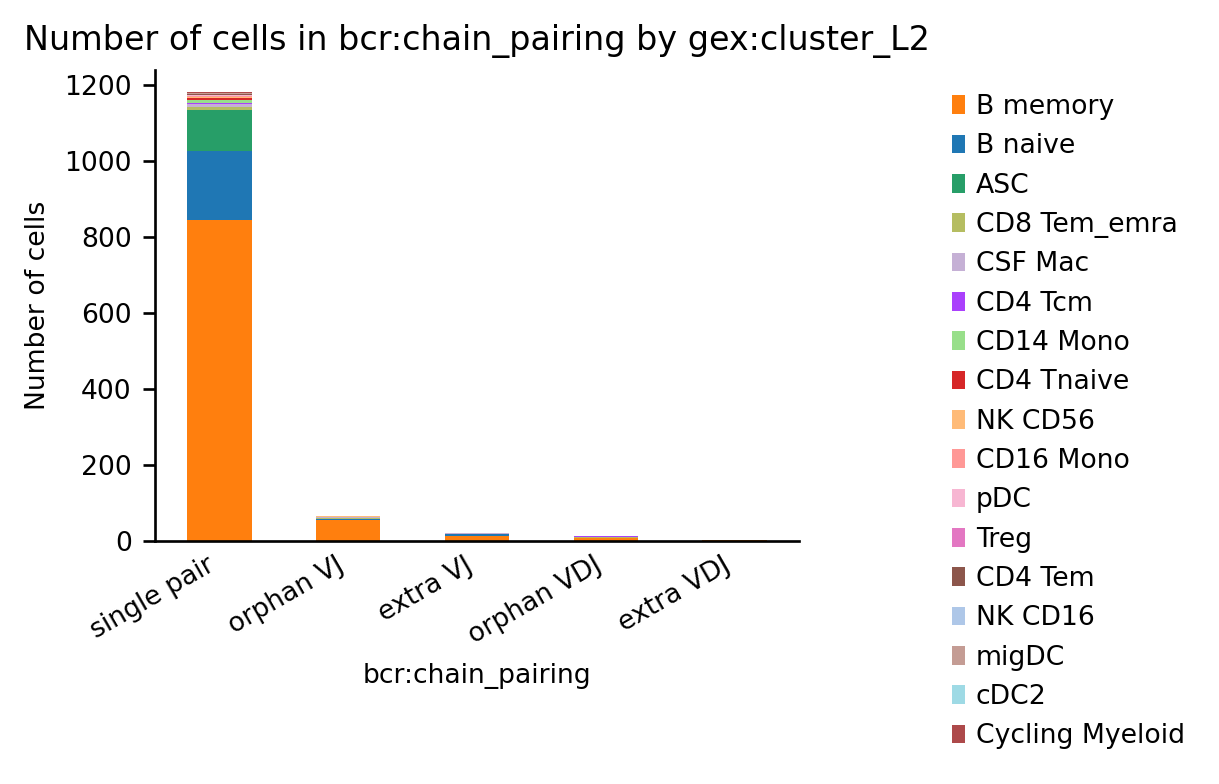

In [19]:
_ = ir.pl.group_abundance(mdata, groupby="bcr:chain_pairing", target_col="gex:cluster_L2")

In [20]:
# using default parameters, `ir_dist` will compute nucleotide sequence identity
ir.pp.ir_dist(mdata, airr_mod='tcr')
ir.tl.define_clonotypes(mdata, airr_mod='tcr', receptor_arms="all", dual_ir="primary_only")

Computing sequence x sequence distance matrix for VJ sequences.
Computing sequence x sequence distance matrix for VDJ sequences.
Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:18)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored result in `mdata.obs["tcr:clone_id"]`.
Stored result in `mdata.obs["tcr:clone_id_size"]`.


In [21]:
ir.tl.clonal_expansion(mdata, airr_mod='tcr')

Stored result in `mdata.obs["tcr:clonal_expansion"]`.


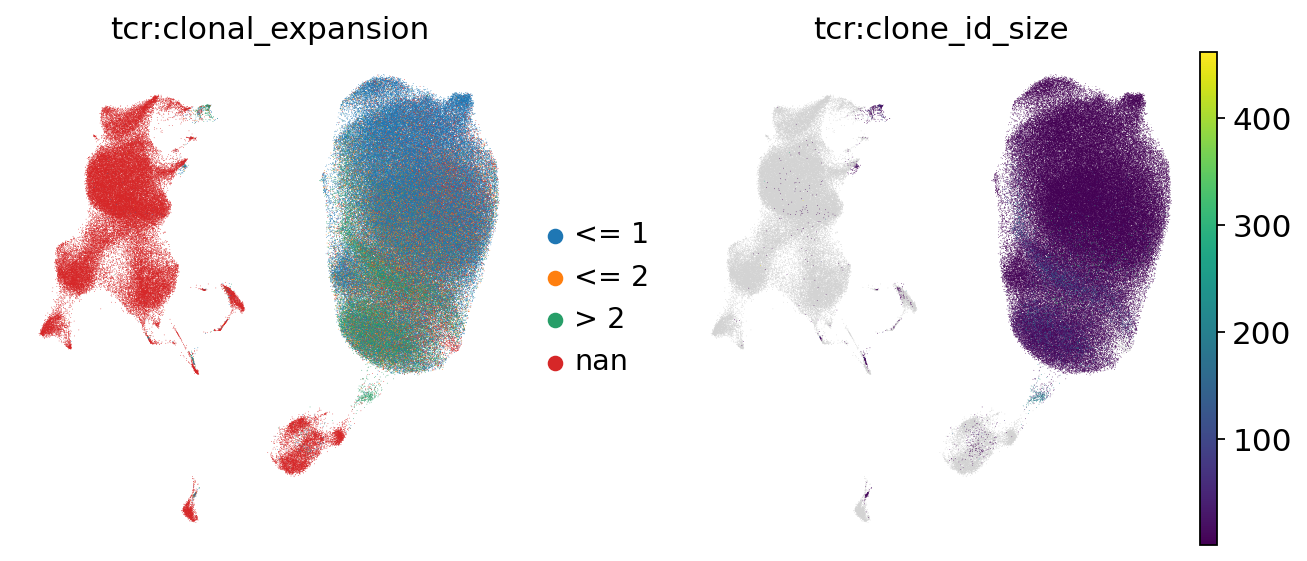

In [22]:
mu.pl.embedding(mdata, basis="gex:umap_filtered", color=["tcr:clonal_expansion", "tcr:clone_id_size"])

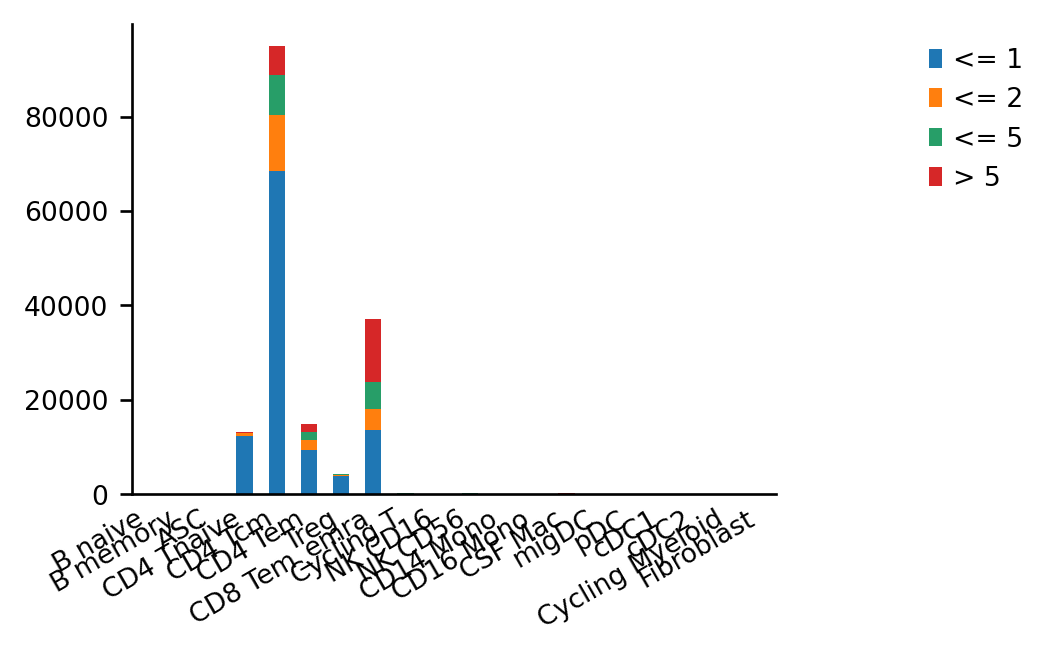

In [23]:
_ = ir.pl.clonal_expansion(mdata, airr_mod='tcr', target_col="clone_id", groupby="gex:cluster_L2", breakpoints=(1, 2, 5), normalize=False)

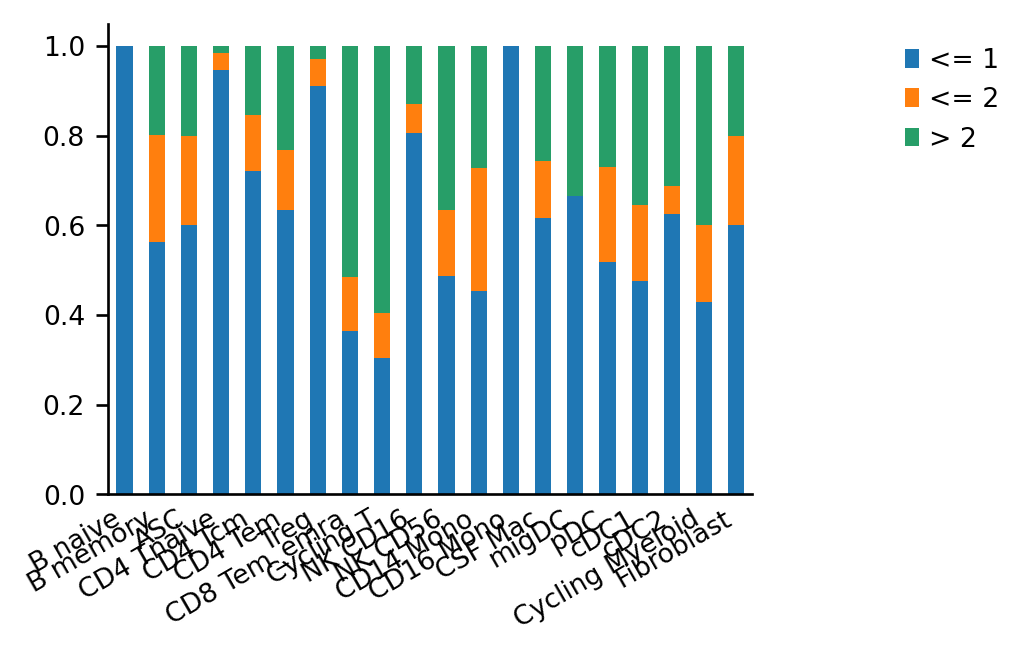

In [24]:
_ = ir.pl.clonal_expansion(
    mdata,
    airr_mod='tcr',
    target_col="clone_id",
    breakpoints=(1, 2),
    groupby="gex:cluster_L2",
    normalize=True,
)

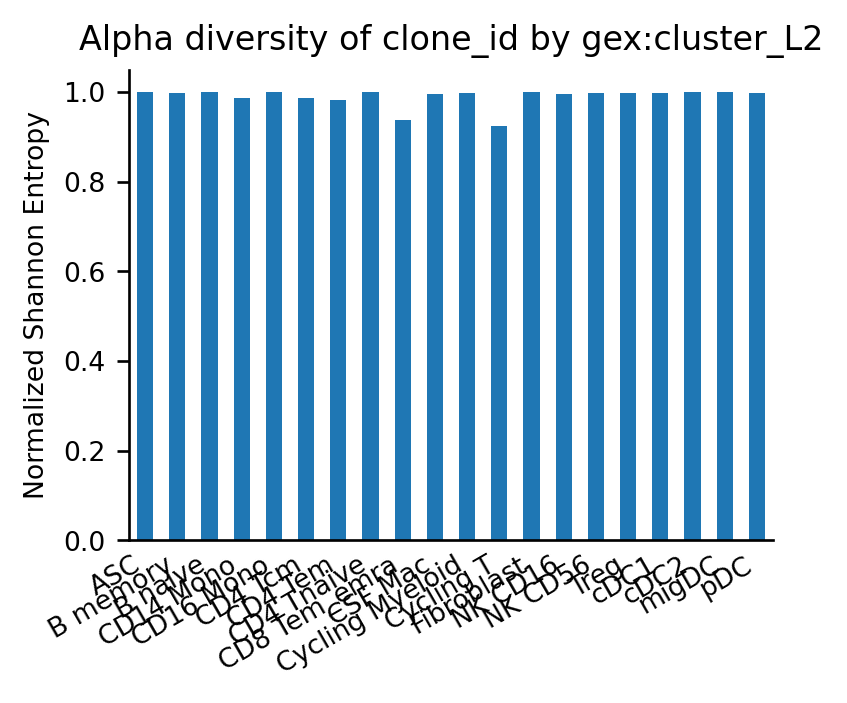

In [25]:
_ = ir.pl.alpha_diversity(mdata, airr_mod='tcr', metric="normalized_shannon_entropy", groupby="gex:cluster_L2")

In [26]:
list_tcell = ['CD4 Tcm',
 'CD8 Tem_emra',
 'CD4 Tem',
 'CD4 Tnaive',
 'Treg',]

In [27]:
mdata

MuData object with n_obs × n_vars = 331058 × 24155
  3 modalities
    gex:	259560 x 24155
      obs:	'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLBAAO', 'AgeDLBDx', 'DLBDxtoConsent', 'PSGinEpic?', 'BirthYear', 'MeetsMDSPDCriteria?', 'PSGDate', 'Ethnicity', 'Race', 'RaceOther', 'PDFamilyHx', 'PDFHMother', 'PDFHFather', 'PDFHFullSibs', 'PDFHHalfSibs', 'PDFHMaternalGPs', 'PDFHPaternalGPs', 'PDFHMaternalAuntsorUncles', 'PDFHChildren', 'PDFHOther', 'DLBFamilyHx', 'DLBFHMother', 'DLBFHFather', 'DLBFHFullSibs', 'DLBFHHalfSibs', 'DLBFHMaternalGPs', 'DLBFHPaternalGPs', 'DLBFHMaternalAuntsorUncles', 'DLBFHChildren', 'DLBFHOther', 'MSAFamilyHx', 'MSAFHMother', 'MSAFHFather', 'MSAFHFullSibs', 'MSAFHHalfSibs', 'MSAFHMaternalGPs', 'MSAFHPaternalGPs', 'MSAFHMaternalAuntsorUncles', 'MSAFHChildren', 'MSAFHOther', 'PDRiskPesticideExposure', 'PDRiskOccupationalsolventExposure', 'PDRiskDrinksCaffeinatedBeverages', 'PDRiskSmokerorFormerSmoker', 'PDRiskPhysicallyActive', 'MeanStriatumSBR', 'MeanStriatumSBR%ile', 'Caudate/PutamenRatio', 'AssymetryIndex', 'OrthostaticHypotension?', 'BloodyTap?', 'ClinicalCSFDataObtained?', 'CSFProtein', 'CSFGlucose', 'ClinicalCSFRBC', 'ClinicalCSFTotalNucleatedCells', 'ClinicalCSFGranulocytes', 'ClinicalCSFLymphocytes', 'CSFClinicalMonocytes', 'CSFVolume', 'CSFTotalCells', 'CSFCells/uL', 'CSFNotes', 'CSFSAA', 'UPSITRawScore', 'UPSITPercentile', 'MOCAVisuospatial', 'MOCA2Naming', 'MOCAMemoryTrial1', 'MOCAMemoryTrial2', 'MOCAAttention', 'MOCALanguage', 'MOCAAbstraction', 'MOCADelayedRecall', 'MOCAMemoryIndexScore', 'MOCAOrientation', 'MOCATotal', 'ParisArousalTotal', 'ConstipationCriteriaScore', 'BMSQ1RisingfromChair', 'BMSQ2Handwriting', 'BMSQ3VoiceSofter', 'BMSQ4PoorBalance', 'BMSQ5FeetGettingStuck', 'BMSQ6FaceLessExpressive', 'BMSQ7ArmsorLegsShaking', 'BMSQ8Buttons', 'BMSQ9Shuffling', 'BMSQ10MoveMoreSlowlythanOthersofAge', 'BMSQTotal', 'LRScore', 'ProbableProdromalPD?', 'SCOPATotal', 'SCPOPAManualEntry', 'NMSSTotal', 'MDS-UPDRS1.1cognition', 'MDS-UPDRS1.2Hallucinations', 'MDS-UPDRS1.3Mood', 'MDS-UPDRS1.4Anxiety', 'MDS-UPDRS1.5Apathy', 'MDS-UPDRS1.6DOPADysregulation', 'MDS-UPDRS1.7Sleep', 'MDS-UPDRS1.8DaytimeSleepiness', 'MDS-UPDRS1.9Pain', 'UMD-UPDRS1.10Urological', 'MDS-UPDRS1.11Constipation', 'MDS-UPDRS1.12OrthostaticDizziness', 'MDS-UPDRS1.13Fatigue', 'MDS-UPDRS2.1Speech', 'MDS-UPDRS2.2Drooling', 'MDS-UPDRS2.3Swallowing', 'MDS-UPDRS2.4Eating', 'MDS-UPDRS2.5Dressing', 'MDS-UPDRS2.6Hygeine', 'MDS-UPDRS2.7Handwriting', 'MDS-UPDRS2.8Hobbies', 'MDS-UPDRS2.9TurninginBed', 'MDS-UPDRS2.10Tremor', 'MDS-UPDRS2.11RisingfromChair,Car,Bed', 'MDS-UPDRS2.12Walking', 'MDS-UPDRS2.13FreezingofGait', 'MDS-UPDRSTakingMeds', 'MDS-UPDRS3.1Speech', 'MDS-UPDRS3.2Facies', 'MDS-UPDRS3.3NeckRigidity', 'MDS-UPDRS3.3RUERigidity', 'MDS-UPDRS3.3LUERidigity', 'MDS-UPDRS3.3RLERidigity', 'MDS-UPDRS3.3LLERigidty', 'MDS-UPDRS3.4FingerTapsR', 'MDS-UPDRS3.4FingerTapsL', 'MDS-UPDRS3.5GraspR', 'MDS-UPDRS3.5GraspL', 'MDS-UPDRS3.6RSMR', 'MDS-UPDRS3.6RSML', 'MDS-UPDRS3.7ToeTapR', 'MDS-UPDRS3.7ToeTapL', 'MDS-UPDRS3.8LegAgilityR', 'MDS-UPDRS3.8LegAgilityL', 'MDS-UPDRS3.9RisingFromC

In [28]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[mdata.obs['gex:SampleID'] == s]['tcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_tcell].T

In [29]:
df_diversity

CD4 Tcm  CD8 Tem_emra   CD4 Tem  CD4 Tnaive      Treg
YPD001CSF  0.989454      0.872010  0.993101    0.998929  0.939111
YPD002CSF  0.976008      0.892458  0.967539    0.996735  1.000000
YPD003CSF  0.987515      0.918497  0.995086    0.999723  0.995834
YPD004CSF  0.995507      0.986658  0.995279    1.000000  1.000000
YPD005CSF  0.994323      0.876643  0.973238    0.999552  0.998896
...             ...           ...       ...         ...       ...
YPD094CSF  0.000000           NaN       NaN         NaN       NaN
YPD073CSF  0.997744      0.991106  0.995620    1.000000  1.000000
YPD093CSF  0.989130      0.952775  0.999306    1.000000  1.000000
YPD096CSF  0.995324      0.935701  0.990806    1.000000  0.994881
YPD097CSF  0.992074      0.916549  0.981464    1.000000  0.992485

[66 rows x 5 columns]

In [30]:
df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='Normalized Shannon Entropy', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

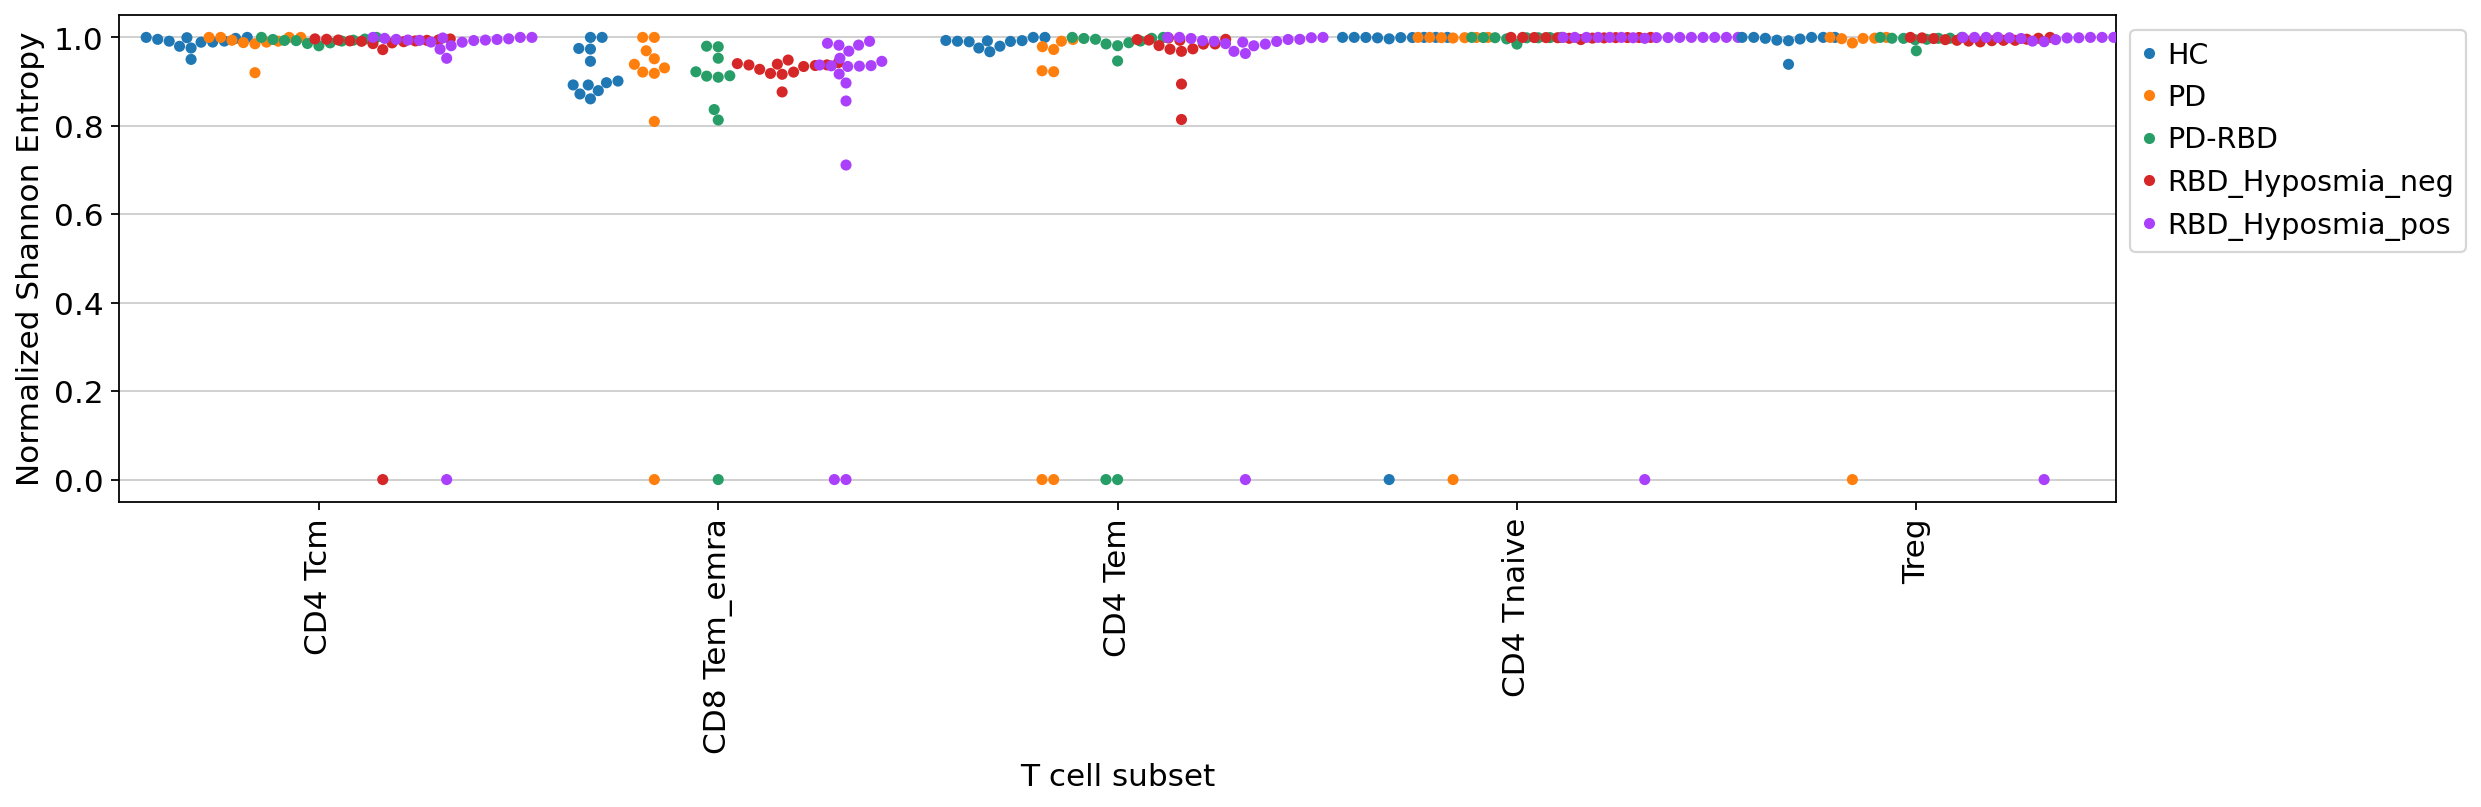

In [31]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


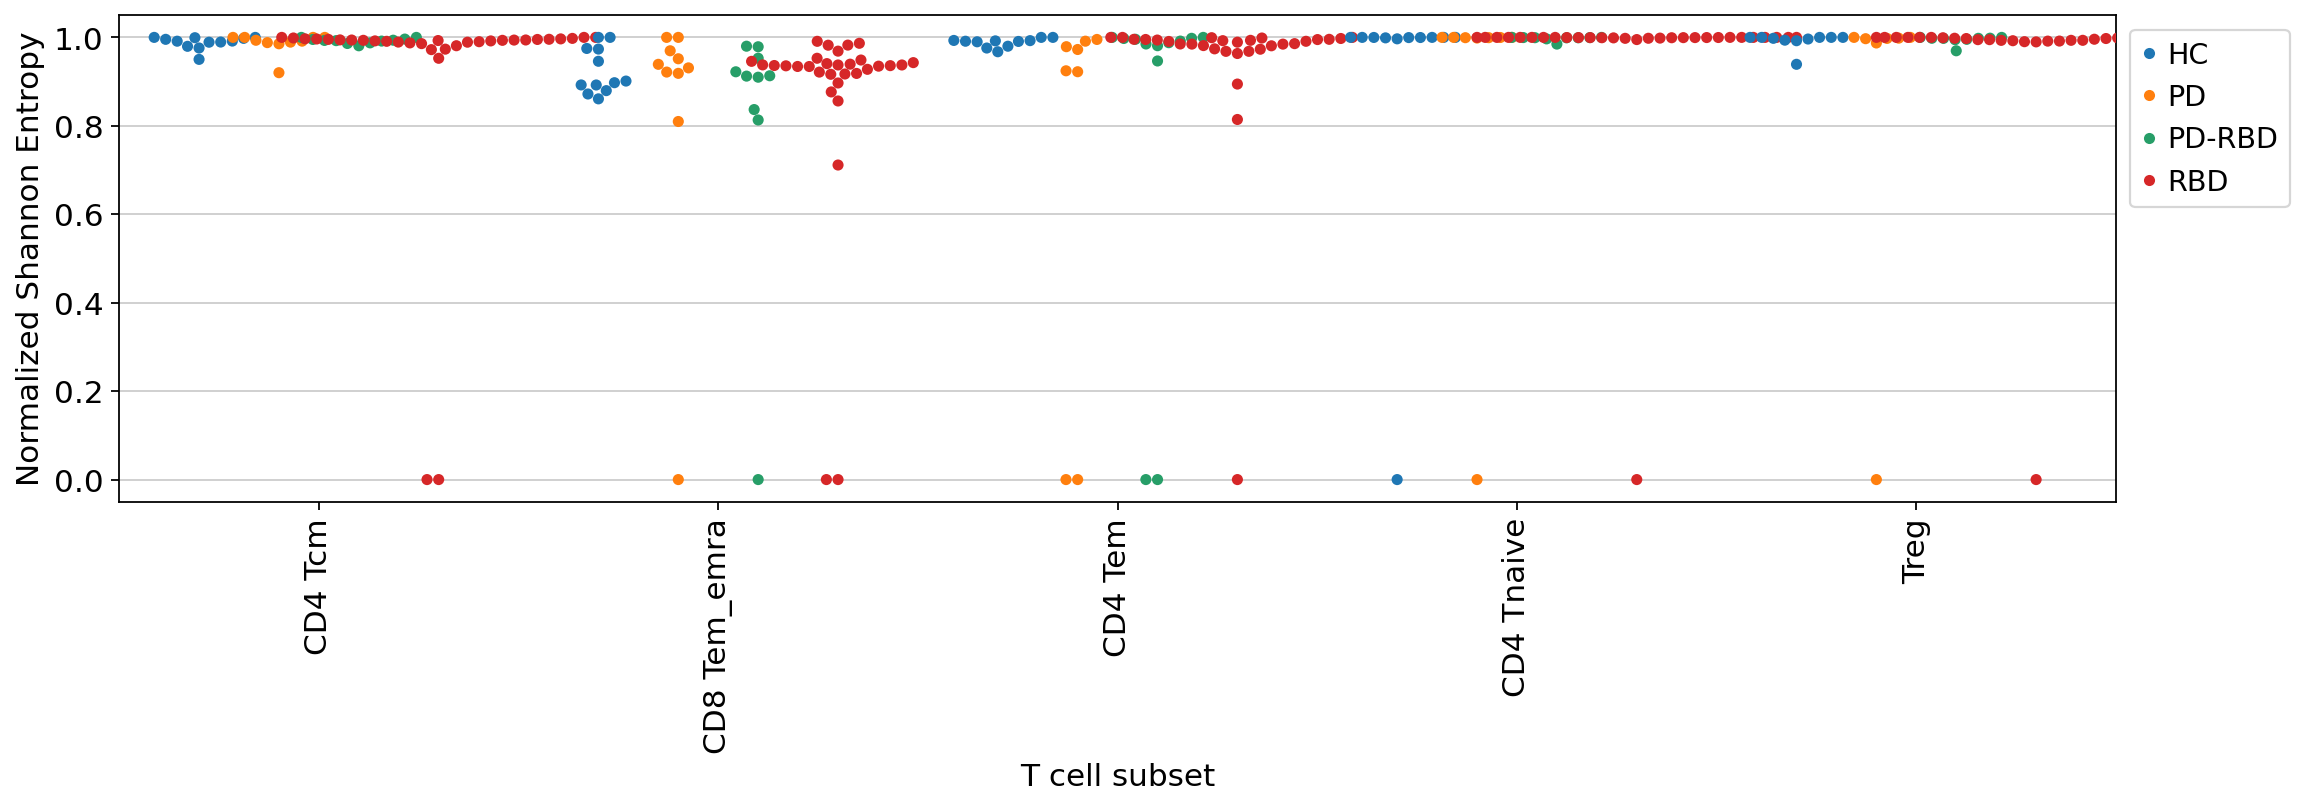

In [32]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [33]:
df_diversity_tidy

index T cell subset  Normalized Shannon Entropy gex:SampleID  \
0    YPD001CSF       CD4 Tcm                    0.989454    YPD001CSF   
1    YPD001CSF  CD8 Tem_emra                    0.872010    YPD001CSF   
2    YPD001CSF       CD4 Tem                    0.993101    YPD001CSF   
3    YPD001CSF    CD4 Tnaive                    0.998929    YPD001CSF   
4    YPD001CSF          Treg                    0.939111    YPD001CSF   
..         ...           ...                         ...          ...   
297  YPD097CSF  CD8 Tem_emra                    0.916549    YPD097CSF   
298  YPD097CSF       CD4 Tem                    0.981464    YPD097CSF   
299  YPD097CSF    CD4 Tnaive                    1.000000    YPD097CSF   
300  YPD097CSF          Treg                    0.992485    YPD097CSF   
301  YPD087CSF       CD4 Tem                    1.000000    YPD087CSF   

    gex:EnrollmentCategory gex:Diagnosis_RBDstrat  
0                       HC                     HC  
1                       HC                     HC  
2                       HC                     HC  
3                       HC                     HC  
4                       HC                     HC  
..                     ...                    ...  
297                    RBD       RBD_Hyposmia_neg  
298                    RBD       RBD_Hyposmia_neg  
299                    RBD       RBD_Hyposmia_neg  
300                    RBD       RBD_Hyposmia_neg  
301                 PD-RBD                 PD-RBD  

[302 rows x 6 columns]

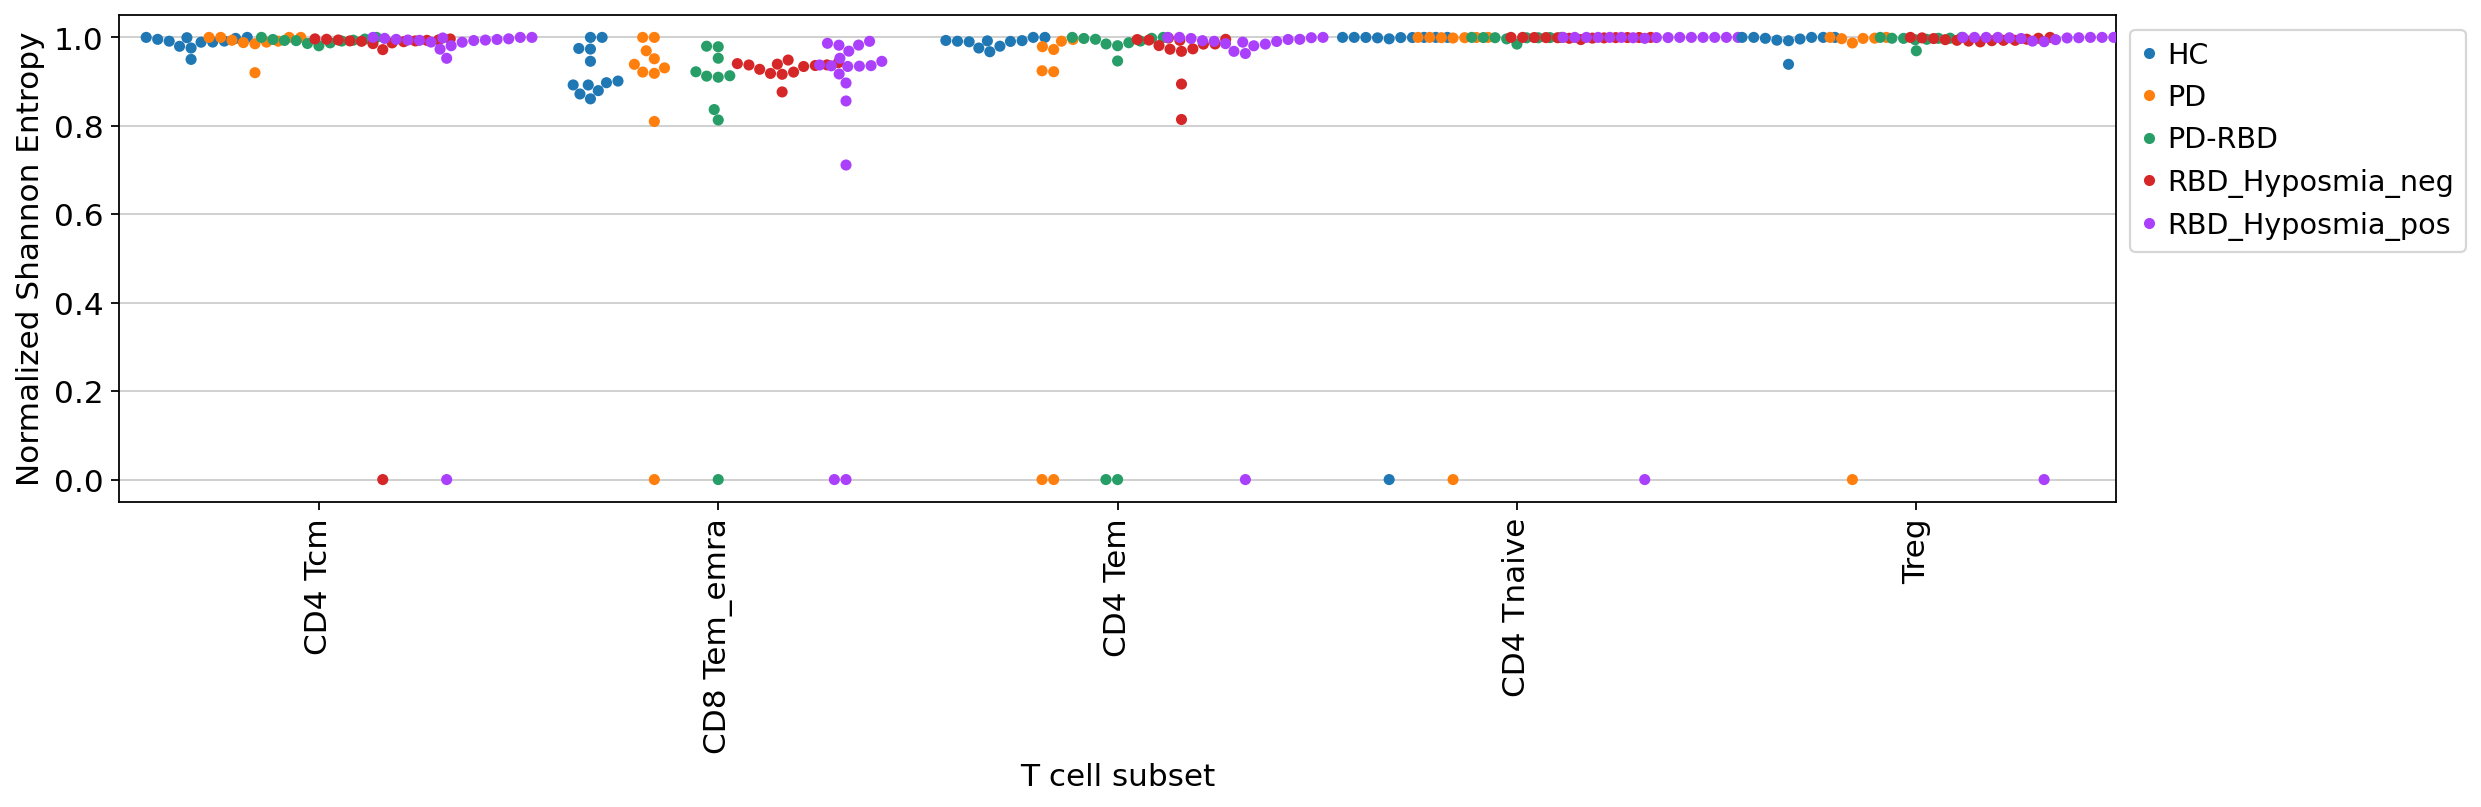

In [34]:
# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_tcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]

plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [35]:
df_p

subset category         p  mean_cat   mean_hc       fdr
0        CD4 Tcm      RBD  0.926484  0.928929  0.988363  0.976275
1        CD4 Tcm       PD  0.667332  0.986815  0.988363  0.976275
2        CD4 Tcm   PD-RBD  0.688391  0.992490  0.988363  0.976275
3   CD8 Tem_emra      RBD  0.776161  0.869331  0.924229  0.976275
4   CD8 Tem_emra       PD  0.716091  0.844156  0.924229  0.976275
5   CD8 Tem_emra   PD-RBD  0.817433  0.821950  0.924229  0.976275
6        CD4 Tem      RBD  0.746082  0.946254  0.988510  0.976275
7        CD4 Tem       PD  0.035159  0.723147  0.988510  0.527392
8        CD4 Tem   PD-RBD  0.877567  0.823643  0.988510  0.976275
9     CD4 Tnaive      RBD  0.976275  0.966126  0.908615  0.976275
10    CD4 Tnaive       PD  0.835383  0.874628  0.908615  0.976275
11    CD4 Tnaive   PD-RBD  0.303051  0.997573  0.908615  0.976275
12          Treg      RBD  0.323496  0.962428  0.991948  0.976275
13          Treg       PD  0.400980  0.854336  0.991948  0.976275
14          Treg   PD-RBD  0.709002  0.994667  0.991948  0.976275

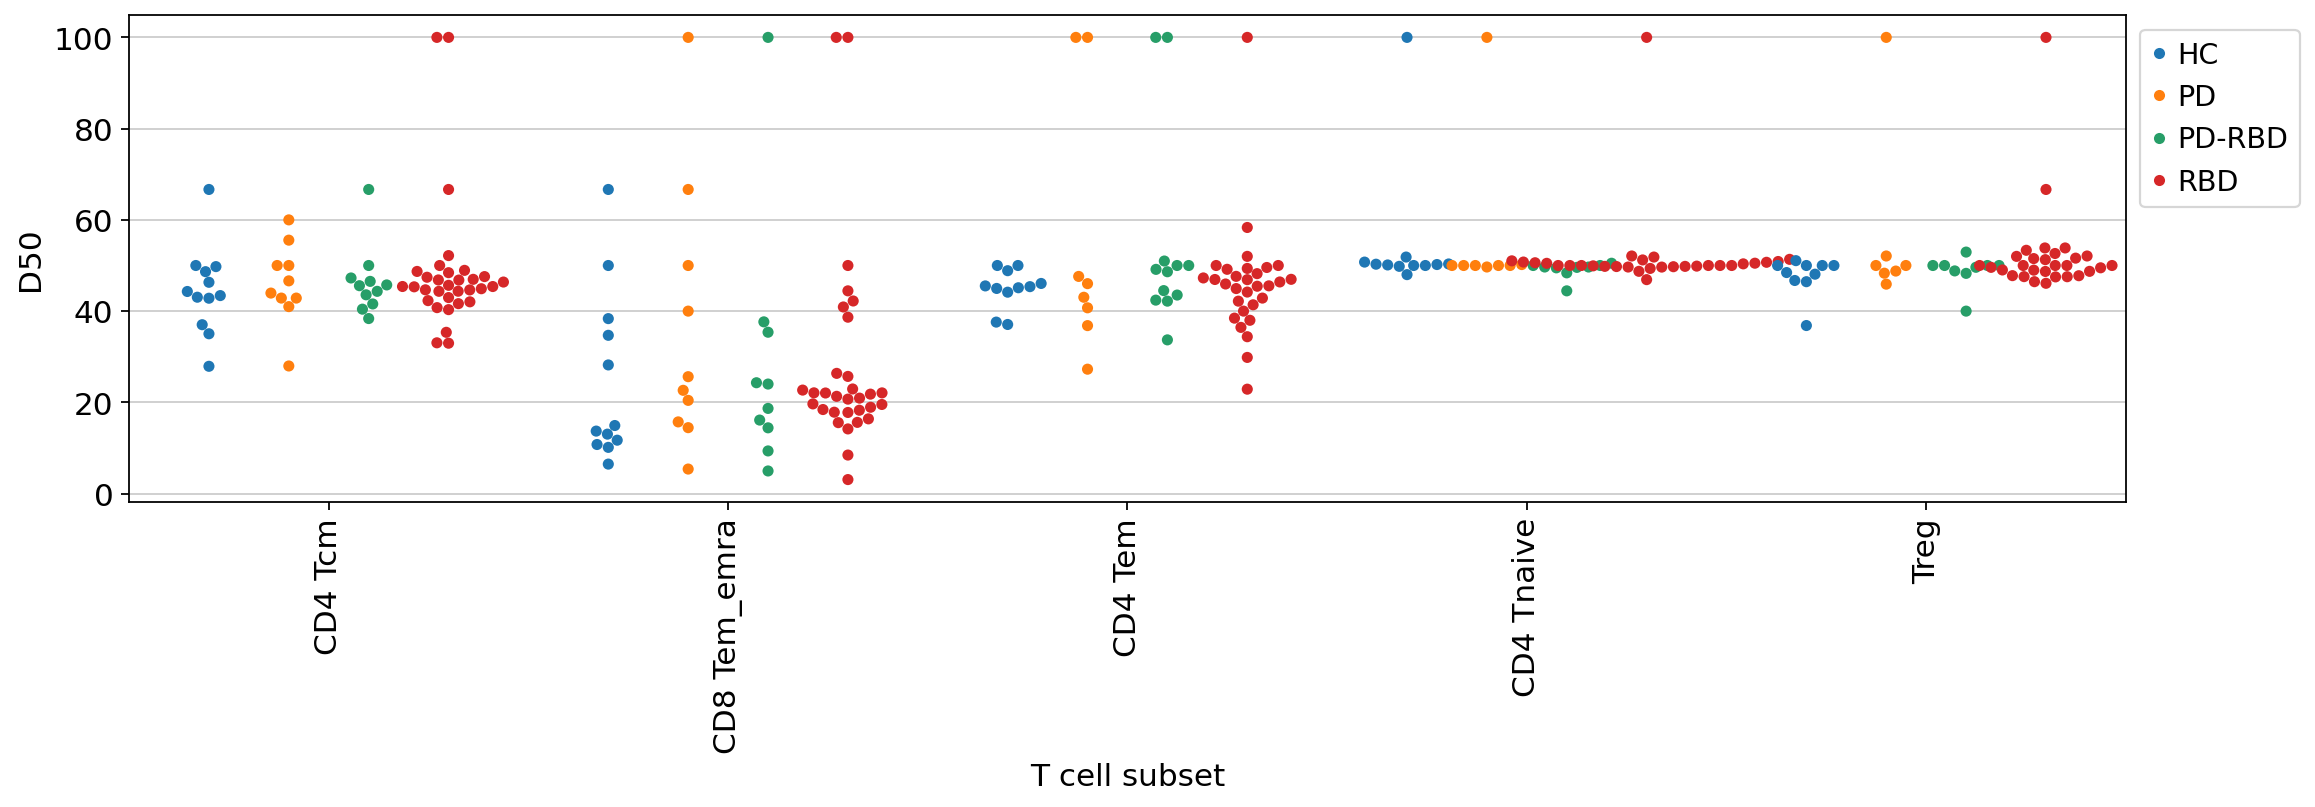

In [36]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[mdata.obs['gex:SampleID'] == s]['tcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='tcr', metric="D50", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_tcell].T

df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='D50', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_tcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]
df_p

plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='D50', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

## BCR

Computing sequence x sequence distance matrix for VJ sequences.


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/scirpy/ir_dist/metrics.py:733: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  data_rows[row_index][0] = data_row_matrix[thread_id, 0:row_end_index].copy()


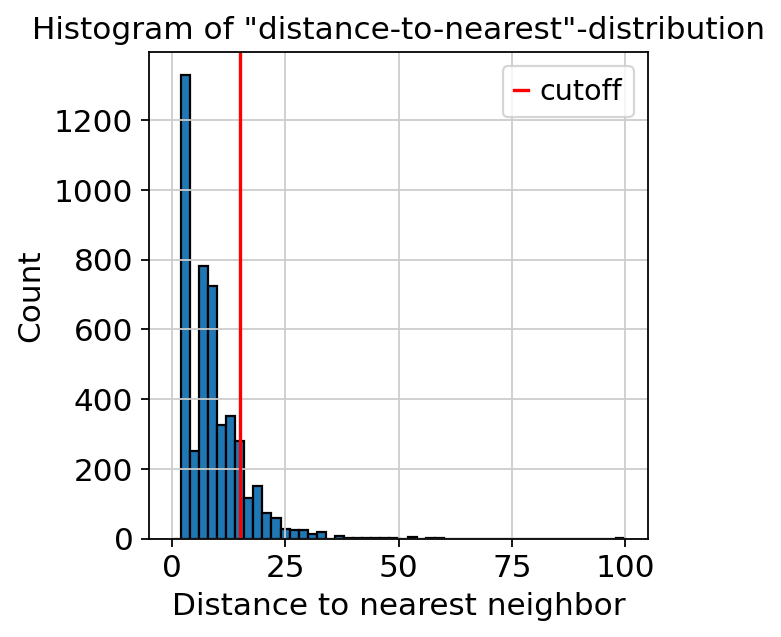

Computing sequence x sequence distance matrix for VDJ sequences.


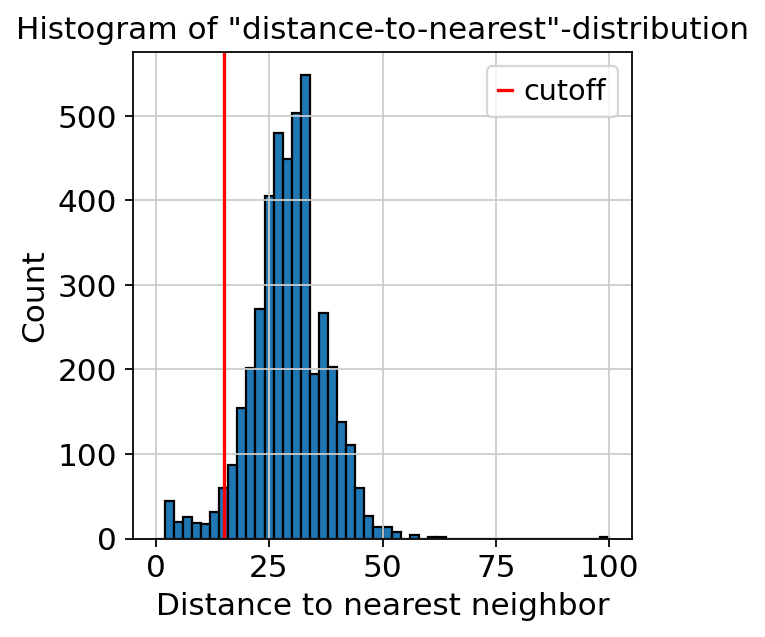

Initializing lookup tables. 
--> Done initializing lookup tables. (0:00:01)
Computing clonotype x clonotype distances.
--> Done computing clonotype x clonotype distances.  (0:00:00)
Stored result in `mdata.obs["bcr:clone_id"]`.
Stored result in `mdata.obs["bcr:clone_id_size"]`.


In [37]:
ir.pp.ir_dist(mdata, airr_mod='bcr', metric="normalized_hamming", cutoff=15, sequence="nt", histogram=True)
ir.tl.define_clonotype_clusters(
    mdata,
    airr_mod='bcr',
    sequence="nt",
    metric="normalized_hamming",
    receptor_arms="all",
    dual_ir="any",
    same_v_gene=True,
    same_j_gene=True,
    # within_group = "gex:patient_id",  # disallow "public" clonotypes
    partitions="fastgreedy",
    key_added="clone_id",
)

In [38]:
ir.tl.clonal_expansion(mdata, airr_mod='bcr', target_col="clone_id", breakpoints=(1, 2))

Stored result in `mdata.obs["bcr:clonal_expansion"]`.


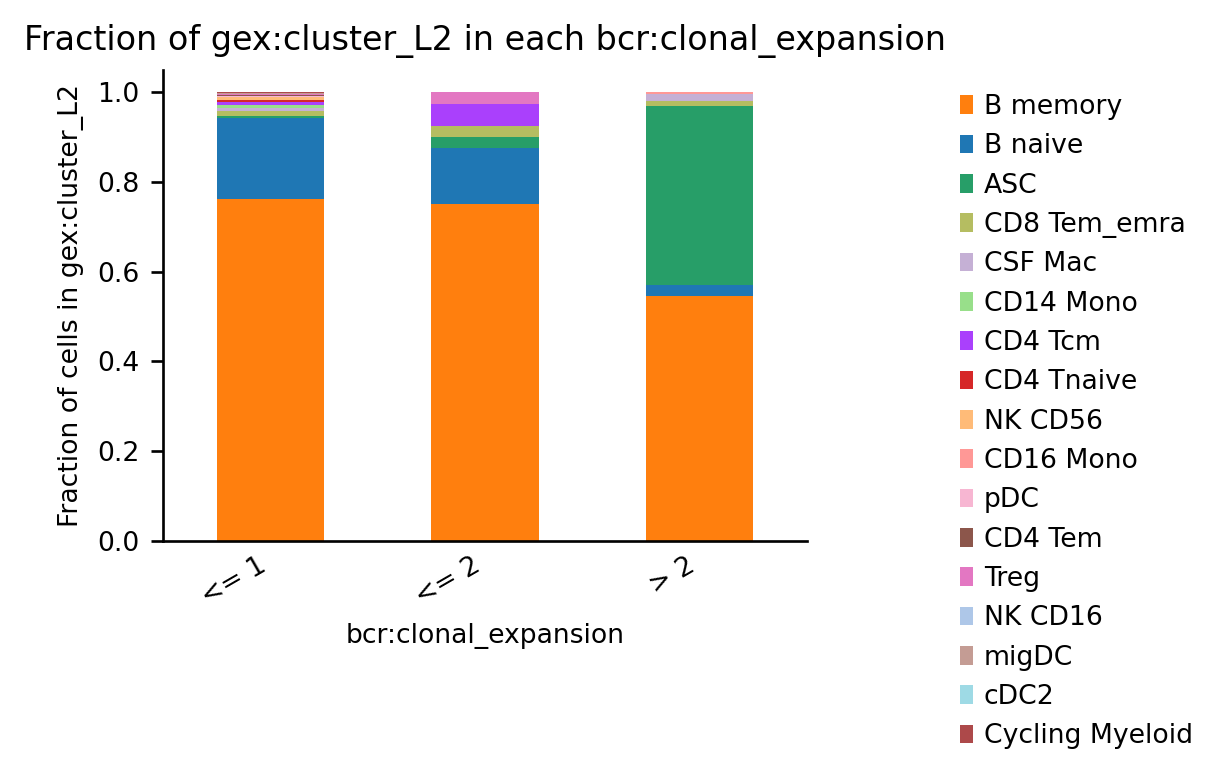

In [39]:
_ = ir.pl.group_abundance(
    mdata,
    target_col="gex:cluster_L2",
    groupby="bcr:clonal_expansion",
    sort=["<= 1", "<= 2", "> 2"],
    normalize=True,
)

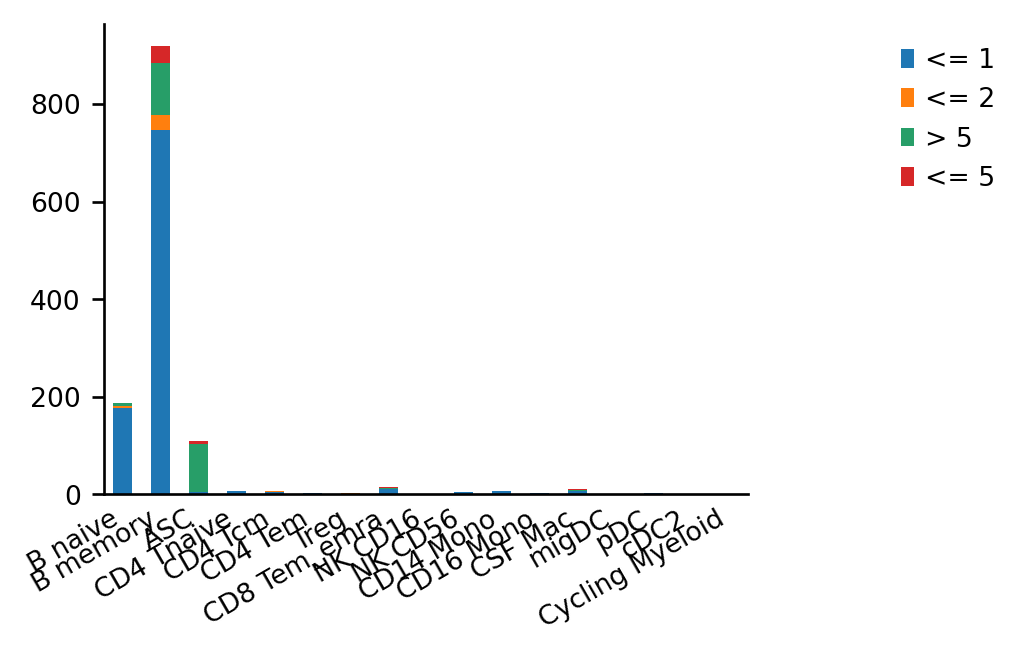

In [40]:
_ = ir.pl.clonal_expansion(mdata, airr_mod='bcr', target_col="clone_id", groupby="gex:cluster_L2", breakpoints=(1, 2, 5), normalize=False)

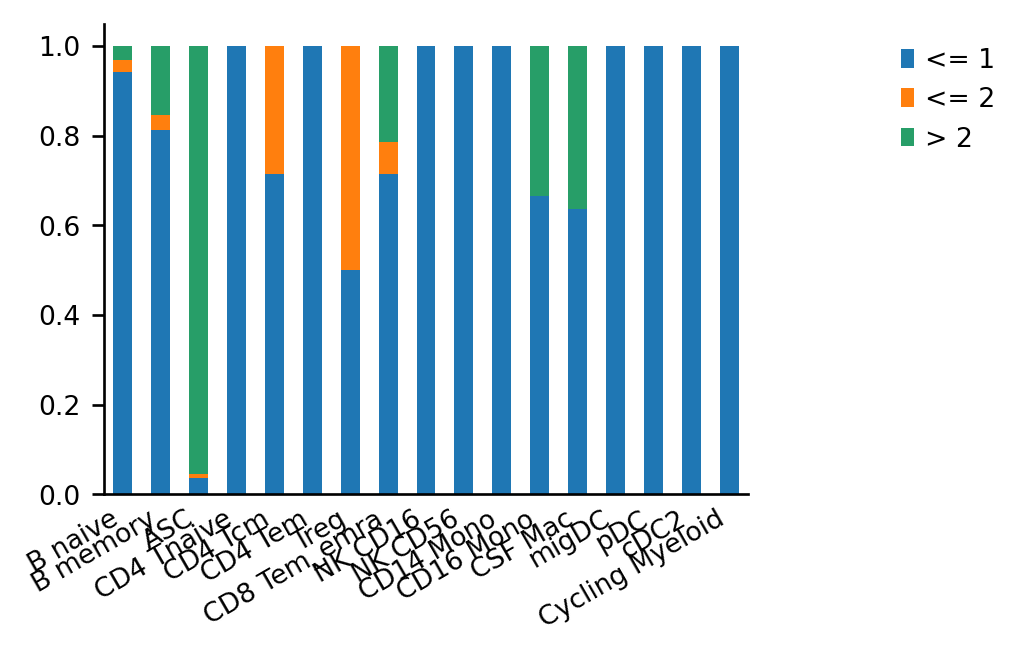

In [41]:
_ = ir.pl.clonal_expansion(
    mdata,
    airr_mod='bcr',
    target_col="clone_id",
    breakpoints=(1, 2),
    groupby="gex:cluster_L2",
    normalize=True,
)

In [42]:
list_bcell = ['B naive', 'B memory', 'ASC']

In [43]:
list_df = []
for s in mdata['bcr'].obs['SampleID'].unique():
    if mdata[mdata.obs['gex:SampleID'] == s]['bcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='bcr', metric="normalized_shannon_entropy", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_bcell].T

In [44]:
df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='Normalized Shannon Entropy', var_name='B cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

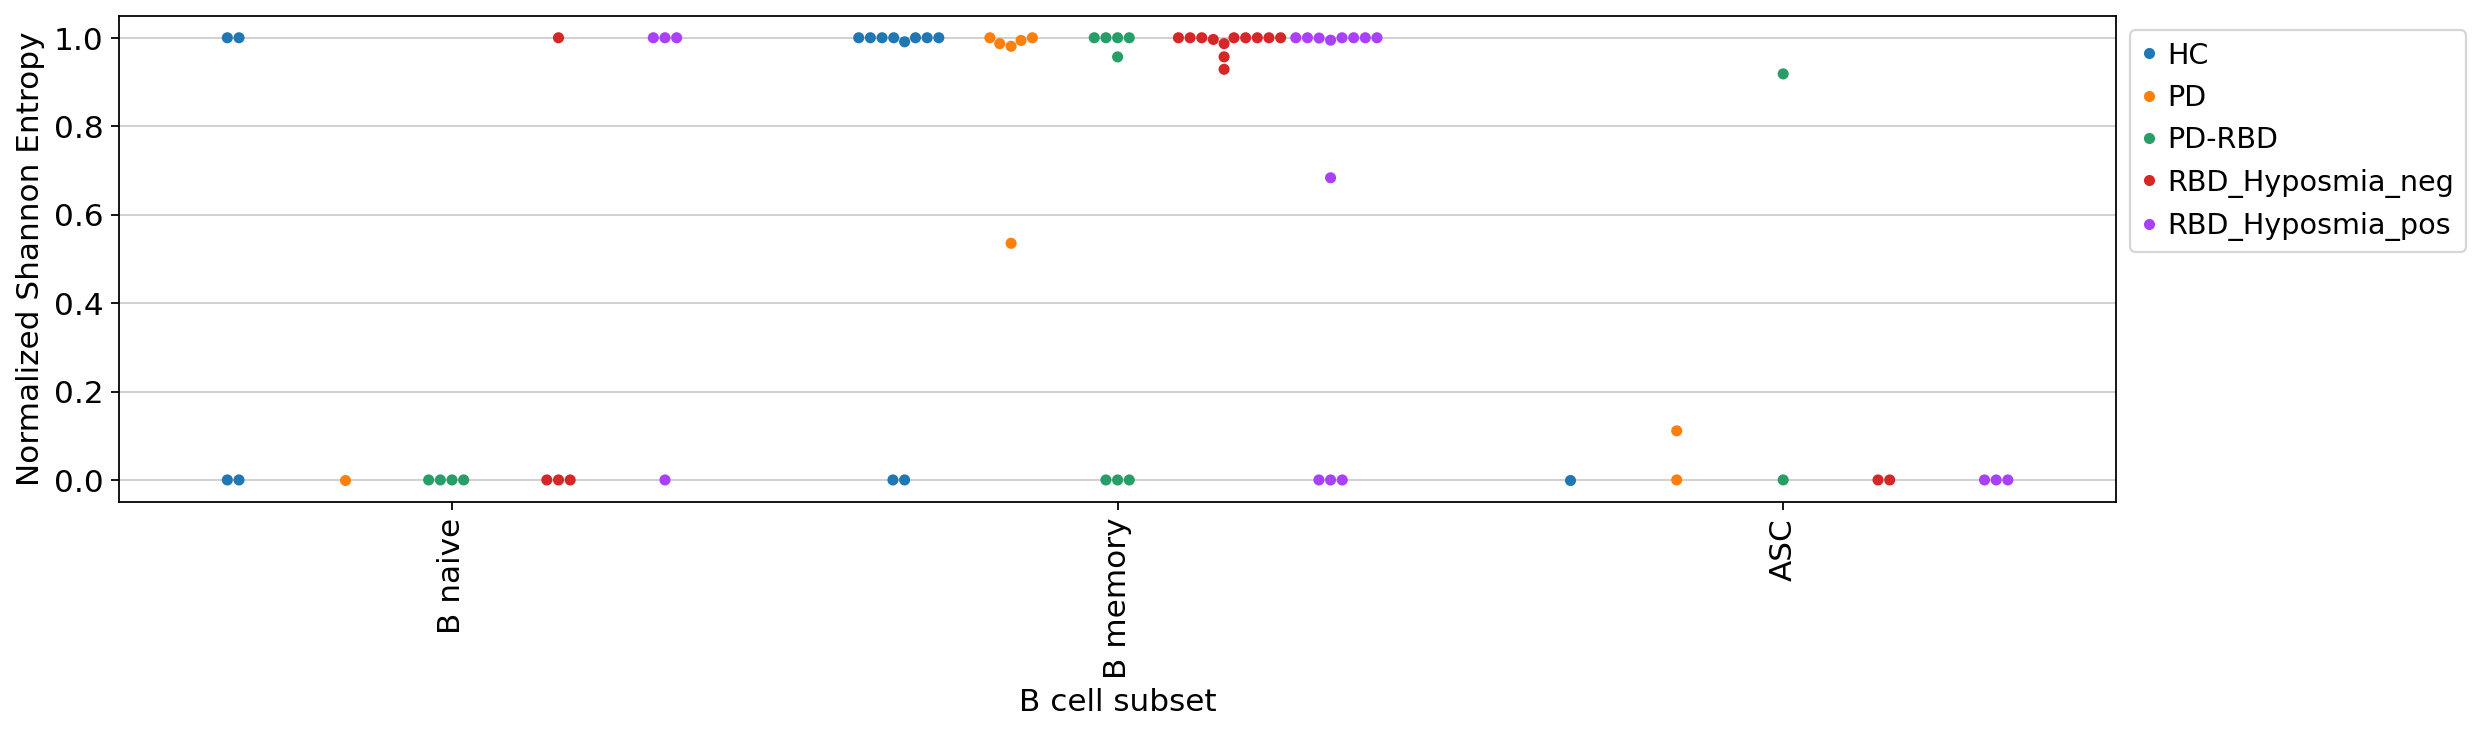

In [45]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='B cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

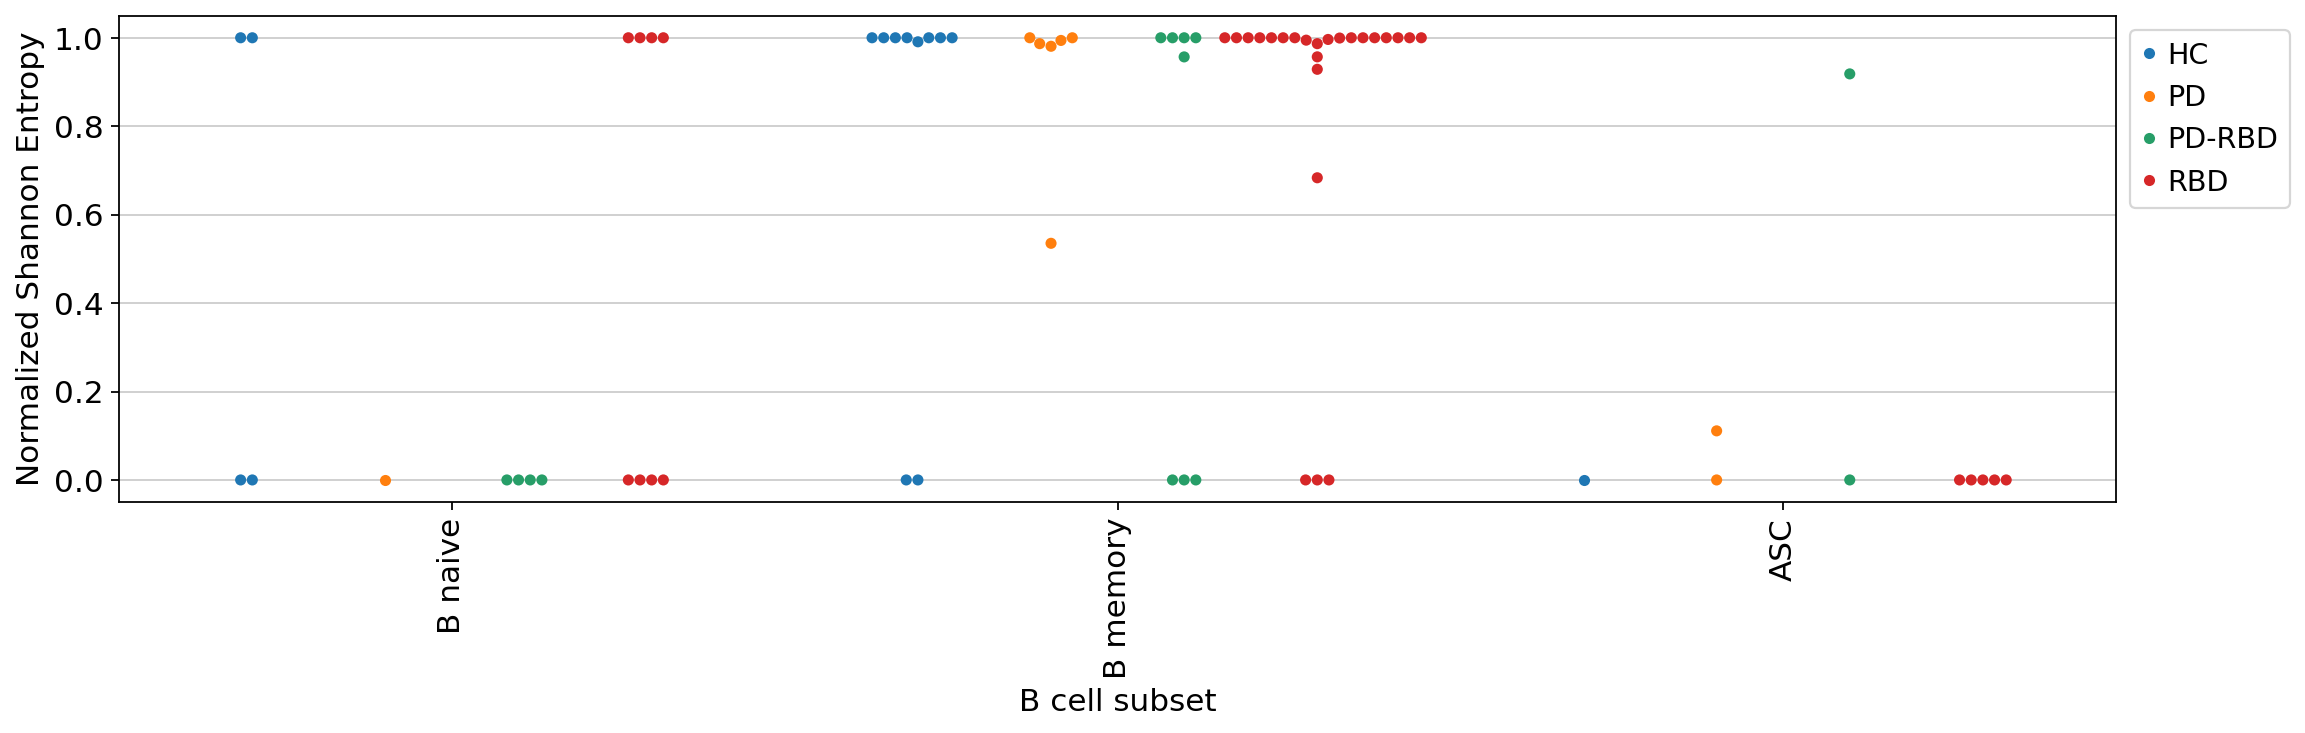

In [46]:
plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='B cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [47]:
# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_bcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['B cell subset'] == subset), 'Normalized Shannon Entropy']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['B cell subset'] == subset), 'Normalized Shannon Entropy']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]

In [48]:
df_p

subset category         p  mean_cat   mean_hc  fdr
0   B naive      RBD  0.924719  0.500000  0.500000  1.0
1   B naive       PD  0.683091  0.000000  0.500000  1.0
2   B naive   PD-RBD  0.181358  0.000000  0.500000  1.0
3  B memory      RBD  0.382824  0.856072  0.799088  1.0
4  B memory       PD  0.468437  0.916094  0.799088  1.0
5  B memory   PD-RBD  0.540784  0.619590  0.799088  1.0
6       ASC      RBD  1.000000  0.000000  0.000000  1.0
7       ASC       PD  1.000000  0.055511  0.000000  1.0
8       ASC   PD-RBD  1.000000  0.459148  0.000000  1.0

subset category         p    mean_cat     mean_hc       fdr
0   B naive      RBD  1.000000   77.162447   77.500000  1.000000
1   B naive       PD  0.692633  100.000000   77.500000  1.000000
2   B naive   PD-RBD  0.185877  100.000000   77.500000  0.702166
3  B memory      RBD  0.372993   55.286795   60.824049  0.839235
4  B memory       PD  0.061518   42.570797   60.824049  0.553659
5  B memory   PD-RBD  0.234055   73.385417   60.824049  0.702166
6       ASC      RBD  1.000000  100.000000  100.000000  1.000000
7       ASC       PD  1.000000   66.666667  100.000000  1.000000
8       ASC   PD-RBD  1.000000   75.000000  100.000000  1.000000

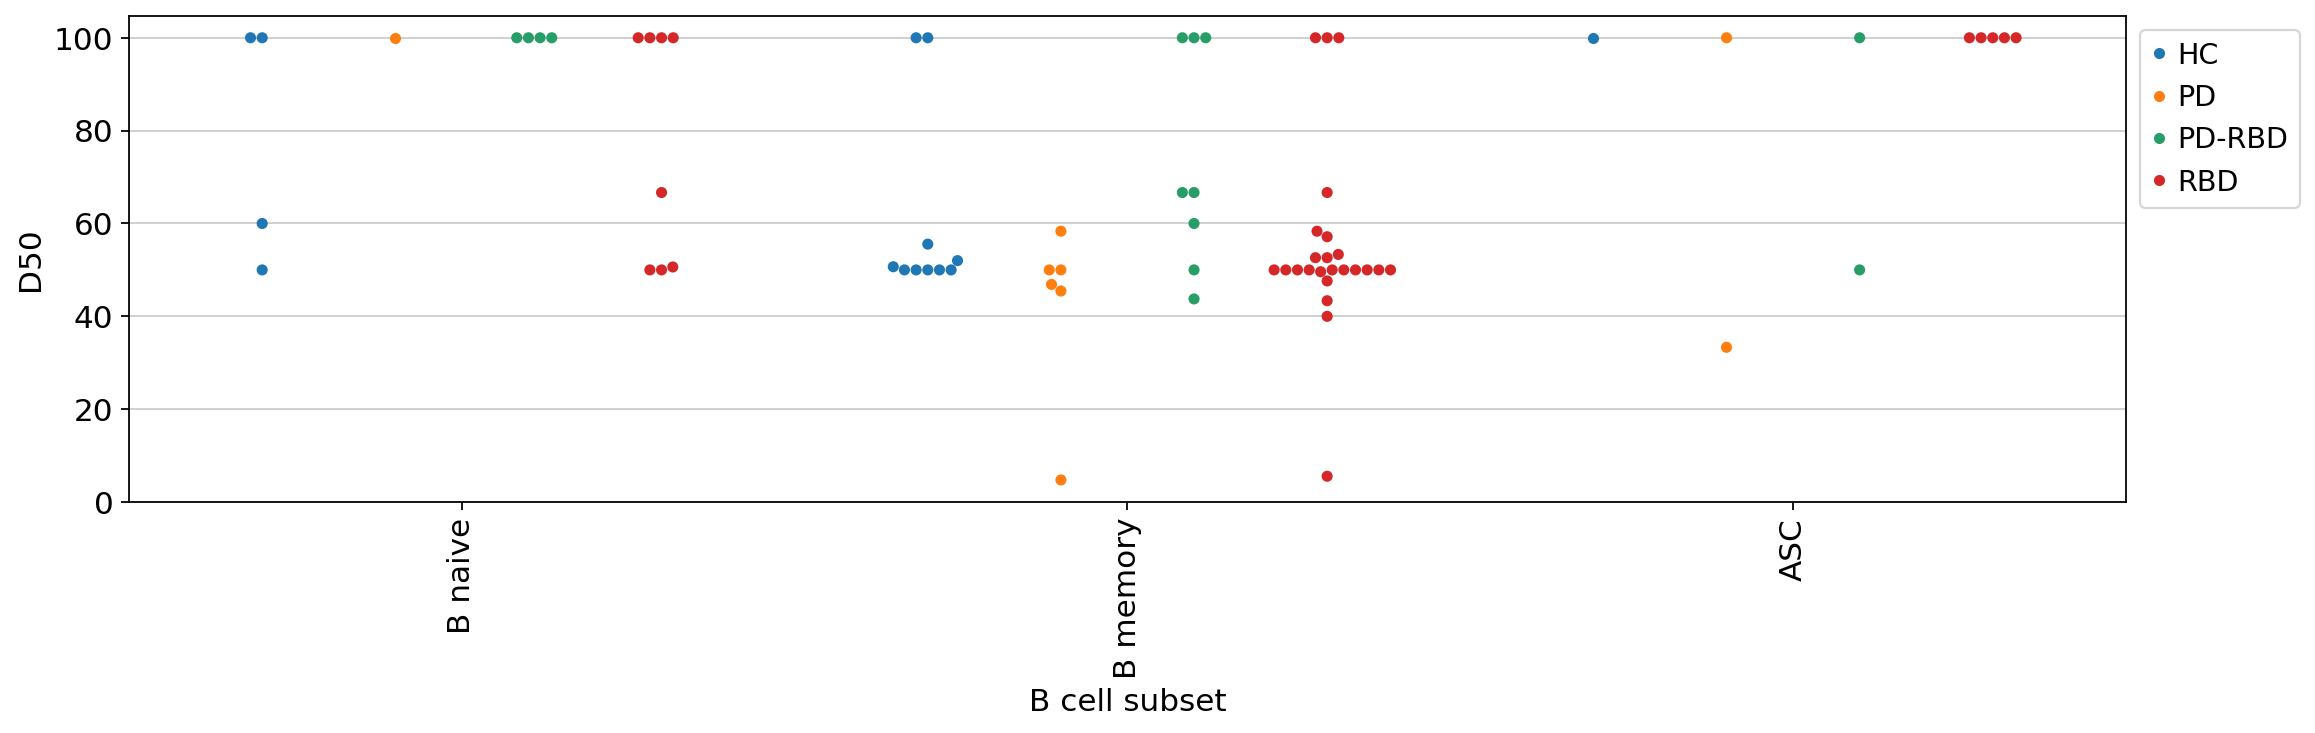

In [49]:
list_df = []
for s in mdata['bcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[mdata.obs['gex:SampleID'] == s]['bcr'].shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
            airr_mod='bcr', metric="D50", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).loc[list_bcell].T

df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='D50', var_name='B cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')

# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in list_bcell:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['B cell subset'] == subset), 'D50']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['B cell subset'] == subset), 'D50']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)

plt.figure(figsize=(16, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='B cell subset', 
    y='D50', 
    hue='gex:EnrollmentCategory',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]
df_p

In [50]:
mdata.write(results_file_mu)

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


## CD4T

In [51]:
mdata = mu.read(results_file_mu)

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/c

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


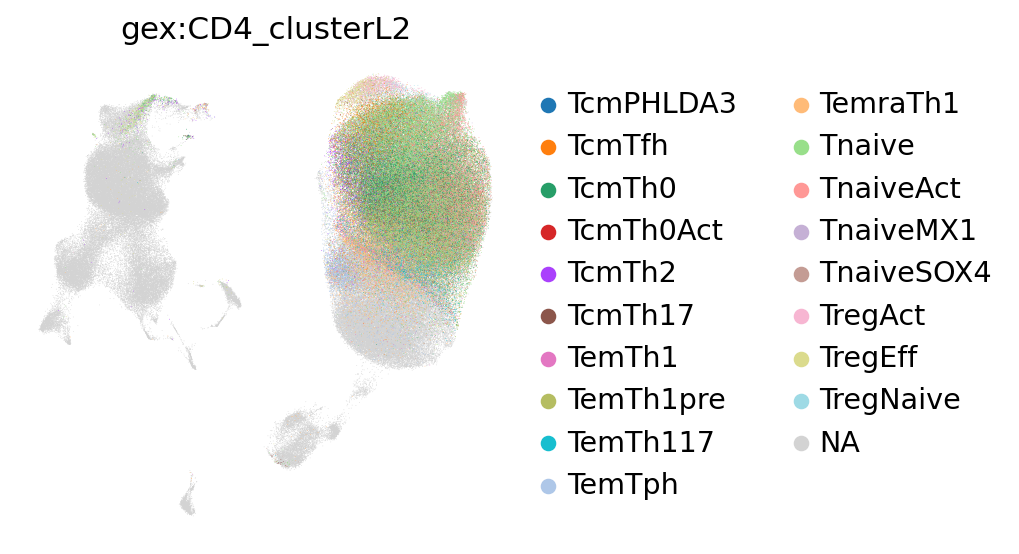

In [52]:
df_cd4 = pd.read_csv('../output/241029_CSF_CD4T_tidy_queryL2_output.full.csv', index_col=0)
df_cd4.index = df_cd4.index + '-' + df_cd4['sample'] + 'CSF'
df_cd4.columns = ['CD4_clusterL1', 'CD4_clusterL1_prob', 'CD4_clusterL2', 'CD4_clusterL2_prob', 'age',
       'sex', 'disease', 'sample']
df_cd4 = df_cd4[['CD4_clusterL1', 'CD4_clusterL1_prob', 'CD4_clusterL2', 'CD4_clusterL2_prob']]

mdata['gex'].obs = pd.merge(mdata['gex'].obs, df_cd4, left_index=True, right_index=True, how='left')
mdata.update()

mu.pl.embedding(mdata, basis="gex:umap_filtered", color=["gex:CD4_clusterL2"])

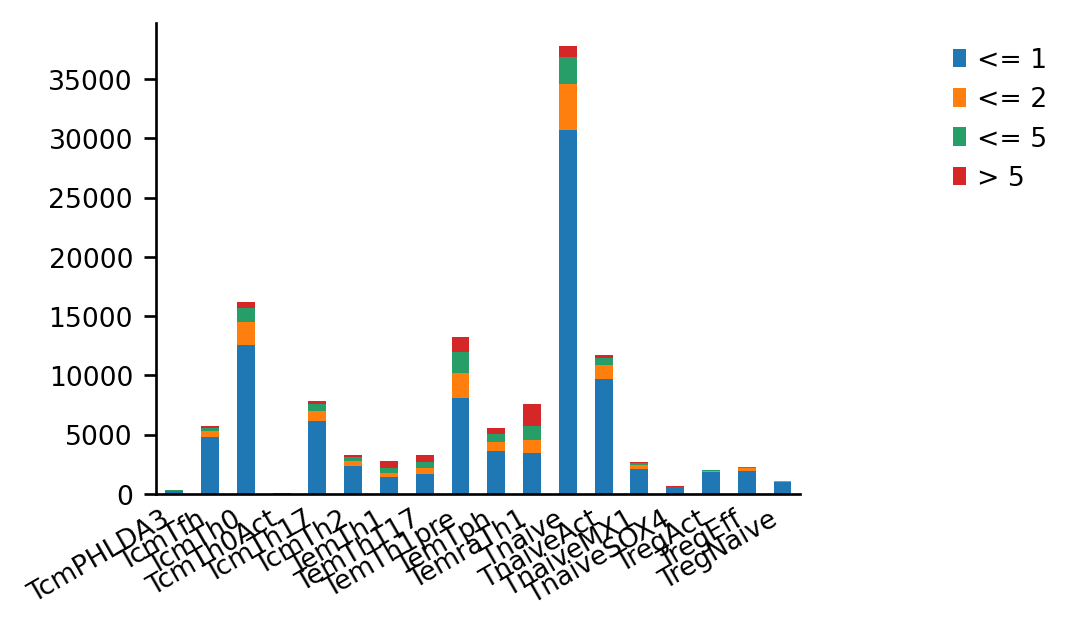

In [53]:
_ = ir.pl.clonal_expansion(mdata, airr_mod='tcr', target_col="clone_id", groupby="gex:CD4_clusterL2", breakpoints=(1, 2, 5), normalize=False)

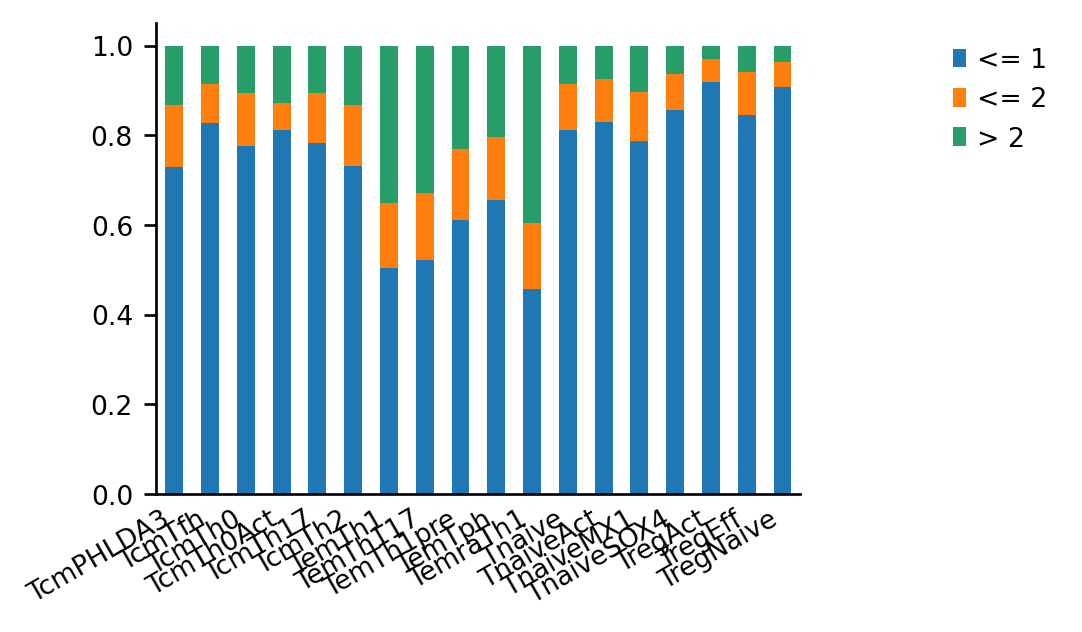

In [54]:
_ = ir.pl.clonal_expansion(
    mdata,
    airr_mod='tcr',
    target_col="clone_id",
    breakpoints=(1, 2),
    groupby="gex:CD4_clusterL2",
    normalize=True,
)

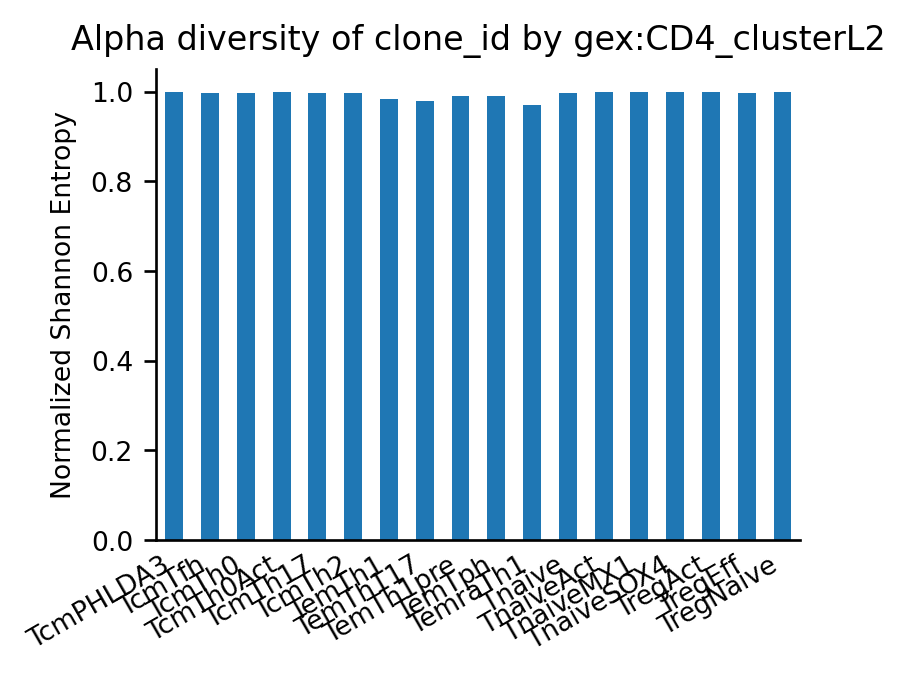

In [55]:
_ = ir.pl.alpha_diversity(mdata, airr_mod='tcr', metric="normalized_shannon_entropy", groupby="gex:CD4_clusterL2")

In [56]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[(mdata.obs['gex:SampleID'] == s)&(mdata.obs['tcr:receptor_type']=='TCR')]['gex'].obs['CD4_clusterL2'].dropna().shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:CD4_clusterL2", 
            airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).T# .loc[list_tcell].T

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 15.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 26.7% of the points cannot be placed; you may want to decrease the size 

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 12.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 13.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 18.8% of the points cannot be placed; you may want to decrease the size 

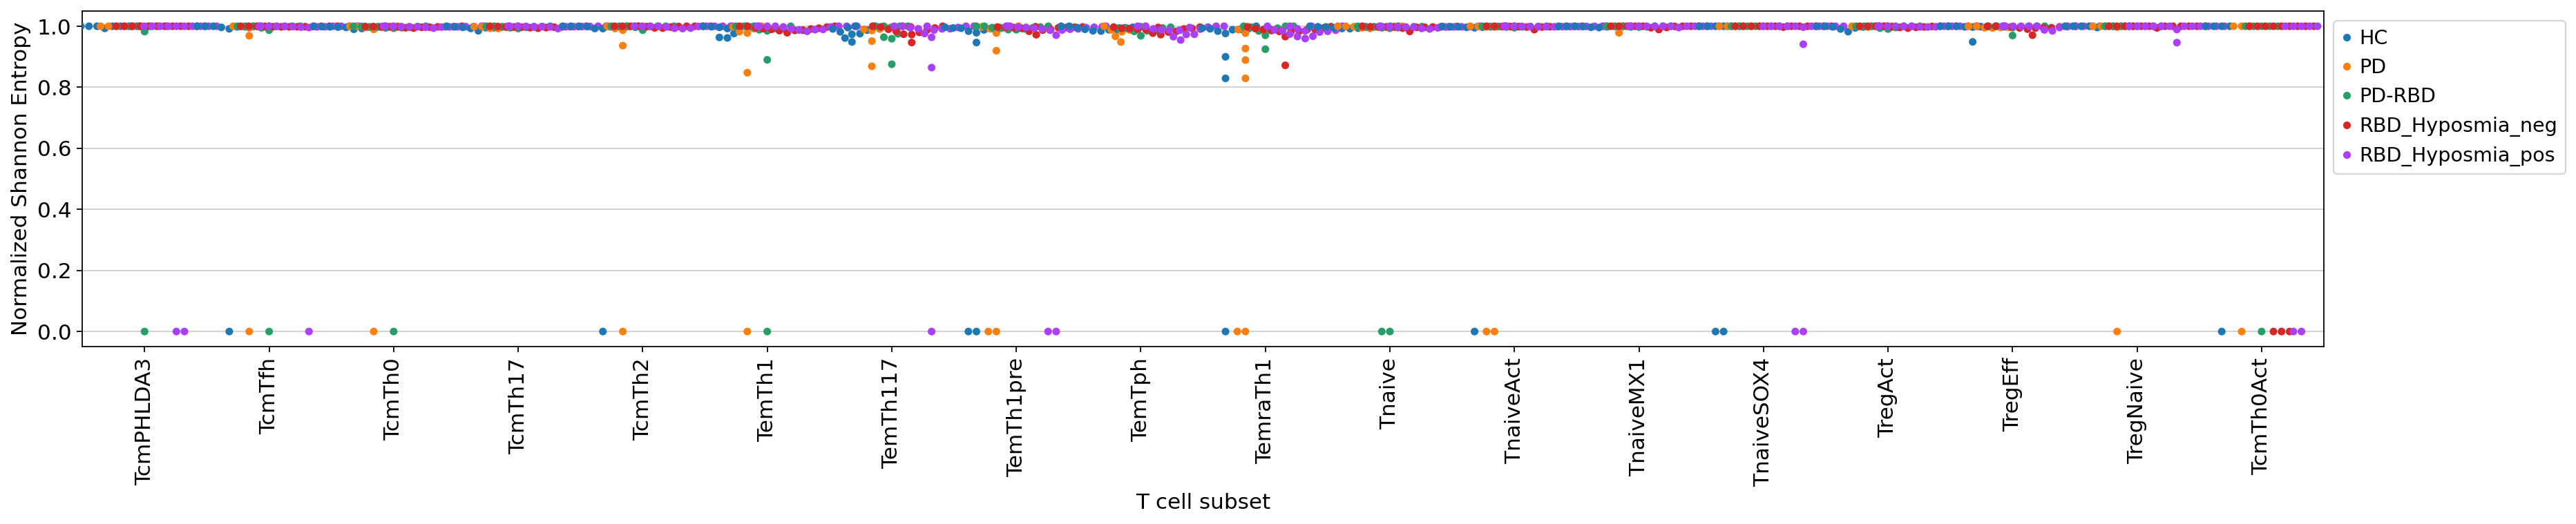

In [57]:
df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='Normalized Shannon Entropy', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')
    
plt.figure(figsize=(26, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='Normalized Shannon Entropy', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [58]:
# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in df_diversity.columns:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'Normalized Shannon Entropy']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]

In [59]:
df_p

subset category         p  mean_cat   mean_hc       fdr
0    TcmPHLDA3      RBD  0.382451  0.916667  0.999221  0.902189
1    TcmPHLDA3       PD  0.080175  1.000000  0.999221  0.618496
2    TcmPHLDA3   PD-RBD  0.768571  0.854653  0.999221  0.927140
3       TcmTfh      RBD  0.603698  0.964743  0.907650  0.927140
4       TcmTfh       PD  0.439989  0.851720  0.907650  0.902189
5       TcmTfh   PD-RBD  0.914768  0.898028  0.907650  1.000000
6       TcmTh0      RBD  0.435089  0.998099  0.996971  0.902189
7       TcmTh0       PD  0.689126  0.872372  0.996971  0.927140
8       TcmTh0   PD-RBD  0.750550  0.906654  0.996971  0.927140
9      TcmTh17      RBD  0.060636  0.998247  0.995934  0.618496
10     TcmTh17       PD  0.704014  0.995986  0.995934  0.927140
11     TcmTh17   PD-RBD  0.389179  0.997656  0.995934  0.902189
12      TcmTh2      RBD  0.477451  0.998548  0.907372  0.902189
13      TcmTh2       PD  0.326979  0.845081  0.907372  0.902189
14      TcmTh2   PD-RBD  0.380937  0.998132  0.907372  0.902189
15      TemTh1      RBD  0.701652  0.994057  0.988643  0.927140
16      TemTh1       PD  0.222229  0.828310  0.988643  0.902189
17      TemTh1   PD-RBD  0.732762  0.884788  0.988643  0.927140
18    TemTh117      RBD  0.287277  0.949379  0.981494  0.902189
19    TemTh117       PD  0.635365  0.963532  0.981494  0.927140
20    TemTh117   PD-RBD  0.743428  0.974561  0.981494  0.927140
21   TemTh1pre      RBD  0.139847  0.926511  0.822528  0.839084
22   TemTh1pre       PD  1.000000  0.764428  0.822528  1.000000
23   TemTh1pre   PD-RBD  0.080148  0.994958  0.822528  0.618496
24      TemTph      RBD  0.486268  0.987876  0.992375  0.902189
25      TemTph       PD  0.306625  0.983107  0.992375  0.902189
26      TemTph   PD-RBD  0.347746  0.988861  0.992375  0.902189
27    TemraTh1      RBD  0.673439  0.981922  0.876822  0.927140
28    TemraTh1       PD  0.199800  0.701173  0.876822  0.902189
29    TemraTh1   PD-RBD  0.136991  0.984644  0.876822  0.839084
30      Tnaive      RBD  0.988564  0.997025  0.996896  1.000000
31      Tnaive       PD  0.371235  0.997903  0.996896  0.902189
32      Tnaive   PD-RBD  0.517923  0.815667  0.996896  0.902189
33   TnaiveAct      RBD  0.050463  0.998827  0.907427  0.618496
34   TnaiveAct       PD  0.675477  0.776655  0.907427  0.927140
35   TnaiveAct   PD-RBD  0.424857  0.998566  0.907427  0.902189
36   TnaiveMX1      RBD  0.943712  0.999096  0.998874  1.000000
37   TnaiveMX1       PD  0.868435  0.996392  0.998874  1.000000
38   TnaiveMX1   PD-RBD  0.619402  0.999214  0.998874  0.927140
39  TnaiveSOX4      RBD  0.024528  0.923524  0.750000  0.618496
40  TnaiveSOX4       PD  0.017177  1.000000  0.750000  0.618496
41  TnaiveSOX4   PD-RBD  0.062394  1.000000  0.750000  0.618496
42     TregAct      RBD  0.224109  0.999110  0.996344  0.902189
43     TregAct       PD  0.427644  0.999332  0.996344  0.902189
44     TregAct   PD-RBD  0.497137  0.997850  0.996344  0.902189
45     TregEff      RBD  0.748146  0.996414  0.994215  0.927140
46     TregEff       PD  0.189770  0.997062  0.994215  0.902189
47     TregEff   PD-RBD  0.934201  0.995788  0.994215  1.000000
48   TregNaive      RBD  0.984372  0.997418  0.999536  1.000000
49   TregNaive       PD  0.505625  0.856777  0.999536  0.902189
50   TregNaive   PD-RBD  0.470541  1.000000  0.999536  0.902189
51   TcmTh0Act      RBD  0.772617  0.736842  0.800000  0.927140
52   TcmTh0Act       PD  1.000000  0.750000  0.800000  1.000000
53   TcmTh0Act   PD-RBD  1.000000  0.833333  0.800000  1.000000

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 6.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


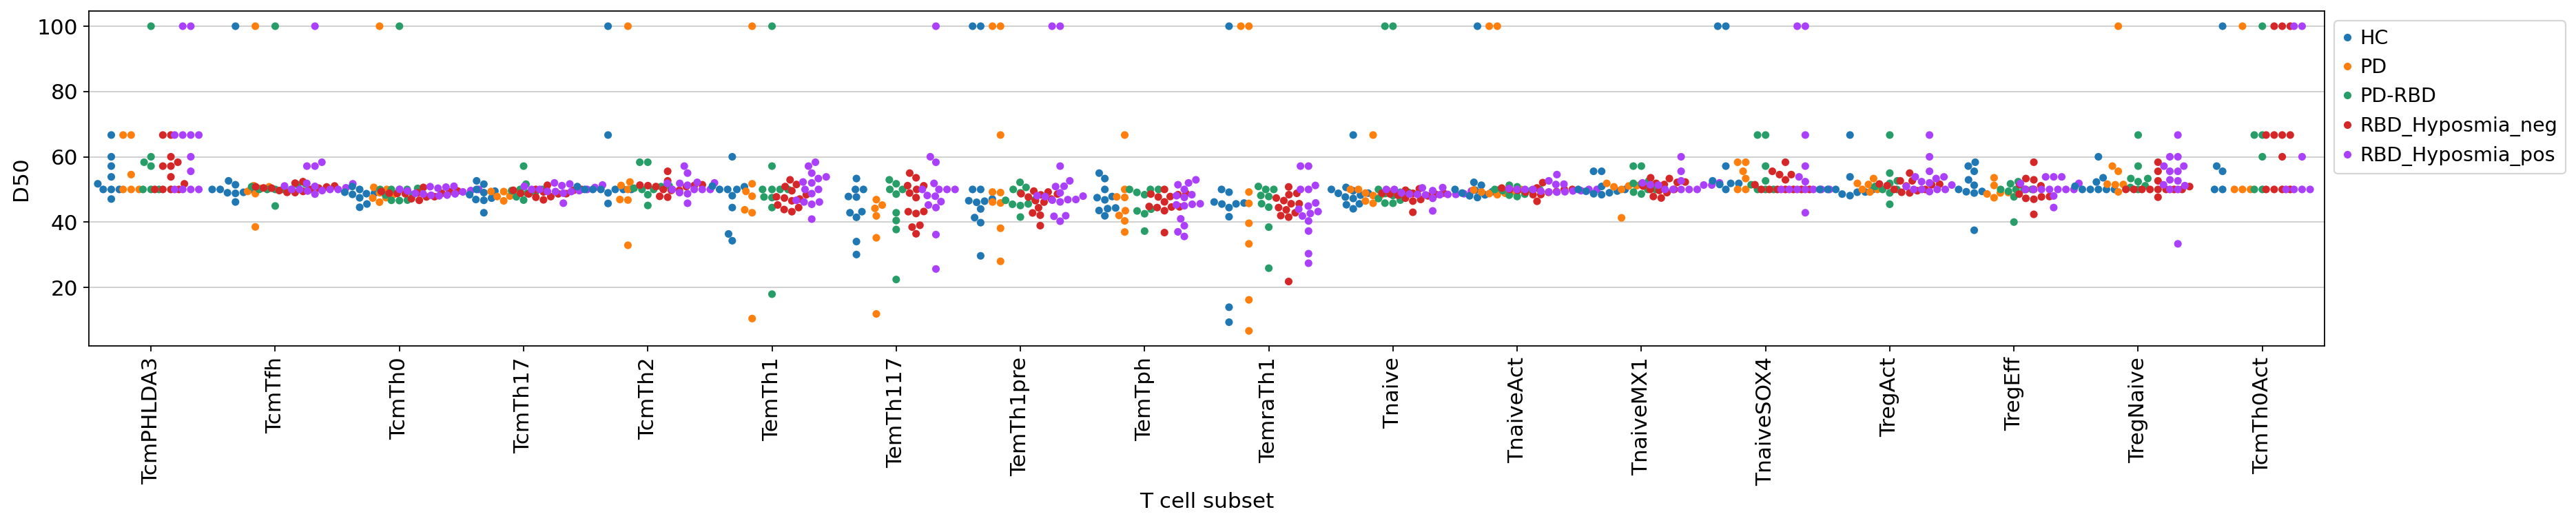

In [60]:
list_df = []
for s in mdata['tcr'].obs['SampleID'].unique():
    # ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:cluster_L2", 
    # airr_mod='tcr', metric="normalized_shannon_entropy", inplace=False)
    if mdata[(mdata.obs['gex:SampleID'] == s)&(mdata.obs['tcr:receptor_type']=='TCR')]['gex'].obs['CD4_clusterL2'].dropna().shape[0] > 0:
        d = ir.tl.alpha_diversity(mdata[mdata.obs['gex:SampleID'] == s], groupby="gex:CD4_clusterL2", 
            airr_mod='tcr', metric="D50", inplace=False)
        d.columns = [s]
        list_df.append(d)
df_diversity = pd.concat(list_df, axis=1).T# .loc[list_tcell].T

df_diversity_tidy = df_diversity.reset_index().melt(
    id_vars='index', value_name='D50', var_name='T cell subset').dropna()

df_diversity_tidy = pd.merge(df_diversity_tidy, 
    mdata.obs[['gex:SampleID', 'gex:EnrollmentCategory', 'gex:Diagnosis_RBDstrat']].dropna().drop_duplicates(),
    left_on='index', right_on='gex:SampleID')
    
plt.figure(figsize=(26, 4))
sns.swarmplot(data=df_diversity_tidy, 
    x='T cell subset', 
    y='D50', 
    hue='gex:Diagnosis_RBDstrat',
    dodge=True)
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [61]:
# mann whitney u test for each subset (EnrollmentCategory)
from scipy.stats import mannwhitneyu

list_p = []
for subset in df_diversity.columns:
    for category in ['RBD', 'PD', 'PD-RBD']:
        s1 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == category)&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        s2 = df_diversity_tidy.loc[(df_diversity_tidy['gex:EnrollmentCategory'] == 'HC')&(df_diversity_tidy['T cell subset'] == subset), 'D50']
        _, p = mannwhitneyu(s1, s2)
        list_p.append({'subset': subset, 'category': category, 'p': p, 'mean_cat': s1.mean(), 'mean_hc': s2.mean()})
df_p = pd.DataFrame(list_p)
df_p['fdr'] = multi.fdrcorrection(df_p['p'])[1]
df_p

subset category         p   mean_cat    mean_hc       fdr
0    TcmPHLDA3      RBD  0.191896  60.572704  54.048738  0.937858
1    TcmPHLDA3       PD  0.713957  56.313131  54.048738  0.937858
2    TcmPHLDA3   PD-RBD  0.549375  60.782313  54.048738  0.937858
3       TcmTfh      RBD  0.235555  52.821000  54.299210  0.937858
4       TcmTfh       PD  0.963788  55.554649  54.299210  0.981973
5       TcmTfh   PD-RBD  0.562074  54.887311  54.299210  0.937858
6       TcmTh0      RBD  0.397831  49.073607  48.296417  0.937858
7       TcmTh0       PD  0.789704  54.869302  48.296417  0.937858
8       TcmTh0   PD-RBD  0.500720  53.361744  48.296417  0.937858
9      TcmTh17      RBD  0.231796  49.535611  48.489000  0.937858
10     TcmTh17       PD  0.792458  48.360081  48.489000  0.937858
11     TcmTh17   PD-RBD  0.368055  50.063827  48.489000  0.937858
12      TcmTh2      RBD  0.514522  50.917813  55.653661  0.937858
13      TcmTh2       PD  0.815462  54.293400  55.653661  0.937858
14      TcmTh2   PD-RBD  0.753447  51.385272  55.653661  0.937858
15      TemTh1      RBD  0.816284  49.095300  47.501080  0.937858
16      TemTh1       PD  0.659767  49.443925  47.501080  0.937858
17      TemTh1   PD-RBD  1.000000  51.470414  47.501080  1.000000
18    TemTh117      RBD  0.206361  48.721314  44.042534  0.937858
19    TemTh117       PD  0.302457  37.537477  44.042534  0.937858
20    TemTh117   PD-RBD  0.805574  44.078130  44.042534  0.937858
21   TemTh1pre      RBD  0.468911  50.498760  53.410233  0.937858
22   TemTh1pre       PD  0.802876  58.110347  53.410233  0.937858
23   TemTh1pre   PD-RBD  0.716476  47.286447  53.410233  0.937858
24      TemTph      RBD  0.740187  45.728273  47.434910  0.937858
25      TemTph       PD  0.476969  46.845708  47.434910  0.937858
26      TemTph   PD-RBD  0.742881  46.070237  47.434910  0.937858
27    TemraTh1      RBD  0.925382  44.025671  44.688293  0.979816
28    TemraTh1       PD  0.901255  48.842093  44.688293  0.979816
29    TemraTh1   PD-RBD  0.493474  44.599805  44.688293  0.937858
30      Tnaive      RBD  0.807543  48.372339  49.389307  0.937858
31      Tnaive       PD  0.476573  50.424351  49.389307  0.937858
32      Tnaive   PD-RBD  0.711787  57.331123  49.389307  0.937858
33   TnaiveAct      RBD  0.582666  50.013328  54.120571  0.937858
34   TnaiveAct       PD  0.878866  60.492836  54.120571  0.979816
35   TnaiveAct   PD-RBD  0.908893  49.565863  54.120571  0.979816
36   TnaiveMX1      RBD  0.116923  51.380614  50.700261  0.937858
37   TnaiveMX1       PD  0.479175  49.362745  50.700261  0.937858
38   TnaiveMX1   PD-RBD  0.233967  52.029503  50.700261  0.937858
39  TnaiveSOX4      RBD  0.110153  55.564567  64.374161  0.937858
40  TnaiveSOX4       PD  0.948133  54.259259  64.374161  0.981973
41  TnaiveSOX4   PD-RBD  0.457244  55.567043  64.374161  0.937858
42     TregAct      RBD  0.056461  52.288778  51.552980  0.937858
43     TregAct       PD  0.315812  50.984448  51.552980  0.937858
44     TregAct   PD-RBD  0.361415  52.383323  51.552980  0.937858
45     TregEff      RBD  0.511494  50.210336  51.033723  0.937858
46     TregEff       PD  0.219780  49.808742  51.033723  0.937858
47     TregEff   PD-RBD  0.483808  49.029353  51.033723  0.937858
48   TregNaive      RBD  0.569170  52.539913  51.869394  0.937858
49   TregNaive       PD  0.237256  59.501253  51.869394  0.937858
50   TregNaive   PD-RBD  0.139861  54.321333  51.869394  0.937858
51   TcmTh0Act      RBD  0.627815  67.719298  62.539683  0.937858
52   TcmTh0Act       PD  0.589639  62.500000  62.539683  0.937858
53   TcmTh0Act   PD-RBD  0.573230  65.555556  62.539683  0.937858

## STARTRAC

In [62]:
df_startrac = mdata.obs[['tcr:clone_id', 'gex:DonorID', 'gex:CD4_clusterL2']].dropna()
df_startrac.columns = ['clone.id', 'patient', 'majorCluster']
df_startrac['loc'] = 'CSF'
df_startrac

df_startrac.to_csv(f'../scanpy/{version}/startrac_input_CD4T.csv')

In [63]:
list_t_crosstissue = ['Tem/Temra cytotoxic T cells',
 'Tem/Trm cytotoxic T cells',
 'Regulatory T cells',
 'Tcm/Naive helper T cells',
 'Tem/Effector helper T cells',
 'Tcm/Naive cytotoxic T cells',]

df_startrac = mdata.obs[['tcr:clone_id', 'gex:DonorID', 'gex:majority_voting_Immune_All_Low']].dropna()
df_startrac.columns = ['clone.id', 'patient', 'majorCluster']
df_startrac['loc'] = 'CSF'
df_startrac = df_startrac[df_startrac['majorCluster'].isin(list_t_crosstissue)]
df_startrac.to_csv(f'../scanpy/{version}/startrac_input_T_crosstissue.csv')
df_startrac

clone.id patient                 majorCluster  \
AAACCTGAGACTTGAA-1-YPD001CSF        0  YPD001  Tem/Effector helper T cells   
AAACCTGGTATGAAAC-1-YPD001CSF        1  YPD001     Tcm/Naive helper T cells   
AAACGGGCACGCTTTC-1-YPD001CSF        2  YPD001    Tem/Trm cytotoxic T cells   
AAAGATGCATGCAATC-1-YPD001CSF        3  YPD001     Tcm/Naive helper T cells   
AAAGATGGTTGTGGAG-1-YPD001CSF        4  YPD001  Tem/Effector helper T cells   
...                               ...     ...                          ...   
TTTGTCATCGTTTATC-1-YPD028CSF    78790  YPD028     Tcm/Naive helper T cells   
TTTGTCATCTCGCATC-1-YPD028CSF    76648  YPD028     Tcm/Naive helper T cells   
TTTGTCATCTGATTCT-1-YPD028CSF    70610  YPD028     Tcm/Naive helper T cells   
TTTGTCATCTGGTGTA-1-YPD028CSF    78791  YPD028     Tcm/Naive helper T cells   
TTTGTCATCTTAACCT-1-YPD028CSF    78792  YPD028     Tcm/Naive helper T cells   

                              loc  
AAACCTGAGACTTGAA-1-YPD001CSF  CSF  
AAACCTGGTATGAAAC-1-YPD001CSF  CSF  
AAACGGGCACGCTTTC-1-YPD001CSF  CSF  
AAAGATGCATGCAATC-1-YPD001CSF  CSF  
AAAGATGGTTGTGGAG-1-YPD001CSF  CSF  
...                           ...  
TTTGTCATCGTTTATC-1-YPD028CSF  CSF  
TTTGTCATCTCGCATC-1-YPD028CSF  CSF  
TTTGTCATCTGATTCT-1-YPD028CSF  CSF  
TTTGTCATCTGGTGTA-1-YPD028CSF  CSF  
TTTGTCATCTTAACCT-1-YPD028CSF  CSF  

[162601 rows x 4 columns]

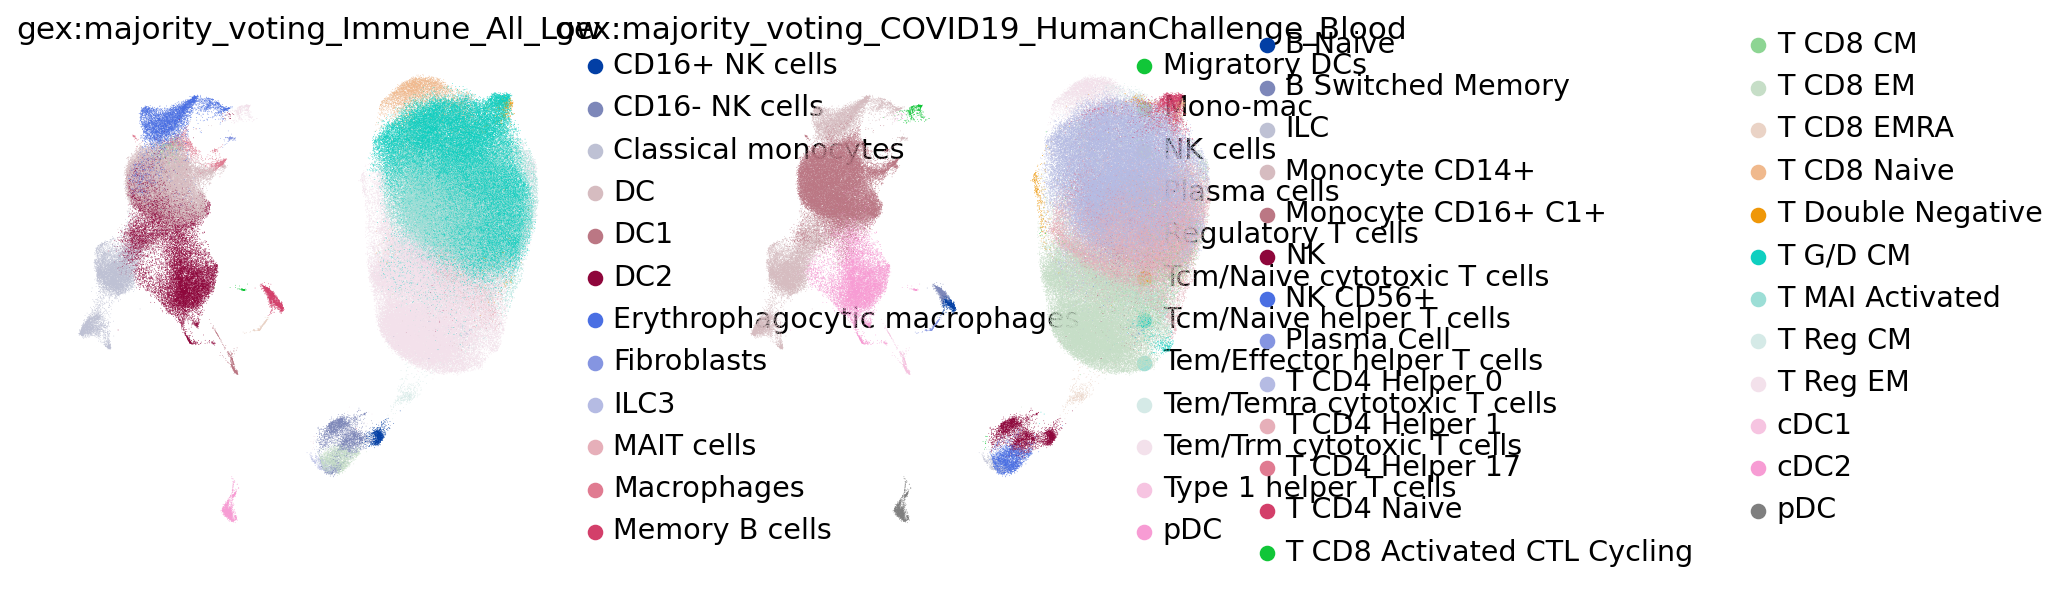

In [64]:
mu.pl.embedding(mdata, basis="gex:umap_filtered", 
    color=['gex:majority_voting_Immune_All_Low',
    'gex:majority_voting_COVID19_HumanChallenge_Blood'])